# 05 模型实现

本 Notebook 中，我们将使用 PyTorch 框架，实现 5 种不同的机器学习模型，并在数据集上进行训练和评估。

## 5.1 数据读取

首先，我们从本地文件中读取数据集，包括分词后的数据集 （`*_seg`）与索引化后的数据集（`*_idx`），以及构建好的词汇表 `vocab`。

In [1]:
from pandas import DataFrame
from MyModule import load_vocab, load_data

train_seg = load_data('data/final/train_segmented.txt', sep='<sp>', is_segmented=True)
val_seg = load_data('data/final/val_segmented.txt', sep='<sp>', is_segmented=True)
test_seg = load_data('data/final/test_segmented.txt', sep='<sp>', is_segmented=True)

train_idx = load_data('data/final/train_index.txt', sep=',', is_indexed=True)
val_idx = load_data('data/final/val_index.txt', sep=',', is_indexed=True)
test_idx = load_data('data/final/test_index.txt', sep=',', is_indexed=True)

vocab = load_vocab('data/final/vocab.txt')

## 5.2 重要概念与机制介绍

本次项目中，我们实现的模型均基于神经网络架构，因此它们的训练、验证与测试过程都遵循深度学习模型的标准流程。

下面，我们将介绍一些在通用标准流程中涉及的重要概念与机制，这些内容有助于理解后续模型的实现与训练过程。

### 5.2.1 类别权重
在 `02Feature Engineering and Data Analysis.ipynb` 中，我们已经观察到数据集标签的分布不平衡情况。

在 `03Data Augmentation.ipynb` 中，我们已经通过 **回译** 的方法对训练集进行了数据增强，以缓解类别不平衡的问题。

然而，两个定量指标（IR 与 CV）均表明：增强后数据集仍有一定的不平衡性，可能会对模型的训练带来影响。

为了进一步缓解由数据不平衡对模型学习造成的干扰，我们在本 Notebook 中引入 **类别权重**（Class Weight）方法。

类别权重方法是指：在计算损失函数时，为不同类别的样本分配不同的权重，从而使得模型在训练过程中更加关注那些样本较少的类别。

具体来说，我们根据每个类别在训练集中的样本数量，计算出每个类别的权重，样本数量越少的类别，其对应的权重越大。

下面的代码展示了如何计算类别权重：

In [2]:
import torch

def class_weights(train_data: DataFrame):  #@save
    """计算类别权重，用于损失函数中的加权"""
    label_counts = train_data["label"].value_counts().values
    class_counts = torch.tensor(label_counts, dtype=torch.float)
    weights = torch.sum(class_counts) / (len(class_counts) * class_counts)
    return weights

在后续训练时，只需将经过 `class_weights` 函数计算得到的权重传递给损失函数即可，如：
```python
weights = class_weights(train_seg)
criterion = nn.CrossEntropyLoss(weight=weights)
```

### 5.2.2 损失函数

为了评估一组参数的好坏，需要有一个准则。在机器学习中，这种准则被称为 **损失函数**（Loss Function）。

简单来说，损失函数用于衡量在训练数据集上模型的输出与真实输出之间的差异。

损失函数的值越小，说明模型的预测结果与真实结果越接近，可以认为此时模型表现越好。

在分类任务中，常用的损失函数是 **交叉熵损失函数**（Cross-Entropy Loss）。

交叉熵损失函数通过计算预测概率分布与真实标签分布之间的差异来评估模型的性能。其公式如下：
$$
\text{CE} = -\frac1m\sum_{i=1}^m\sum_{j=1}^c y_j^{(i)}\log{\hat{y}_j^{(i)}}
$$

式中，$m$ 表示样本的数量，$c$ 是类别数，$y_j^{(i)}$ 表示第 $i$ 个样本的第 $j$ 类上的真实输出结果，只有正确的类别输出才为 $1$，其他类别输出为 $0$；$\hat{y}_j^{(i)}$ 表示模型对第 $i$ 个样本属于第 $j$ 类的预测概率。

于是，最终交叉熵损失函数值只取决于**模型对正确类别预测概率的对数值**。

模型表现越好，预测的概率越大，由于公式右侧前面还有一个负号，所以交叉熵损失越小，这是符合直觉的。

另外，由于交叉熵损失只取决于正确类别的预测结果，所以公式还可以进一步化简：
$$
\text{CE}=-\frac1m\sum_{i=1}^m\log{\hat{y}_t^{(i)}}
$$

式中，$\hat{y}_t^{(i)}$ 表示模型对第 $i$ 个样本在正确类别 $t$ 上的预测概率。

因此，交叉熵损失也被称为 **负对数似然损失**（Negative Log Likelihood, NNL）。

若加入类别权重，只对正确类别 $t$ 加权，公式变为：
$$
\text{CE}_{\text{weighted}}=\frac1m\sum_{i=1}^m w_{t^{(i)}}\log{\hat{y}_t^{(i)}}
$$
式中，$t^{(i)}$ 是第 $i$ 个样本的真实类别，$w_{t^{i}}$ 是该类别的权重。

加入类别权重后：
- **权重越大，惩罚越大**。模型将更重视该类别的错误
- **权重越小，惩罚越小**。模型将降低该类别对梯度的影响

之所以交叉熵损失的学习速度更高，是因为当模型错误较大时，即对正确类别的预测结果偏小（趋近于 $0$），负对数的值会非常大；而当模型错误较小时，即对正确类别的预测结果偏大（趋近于 $1$），负对数的值会趋近于 $0$。

这种变化呈指数形，即当模型错误较大时，损失函数的梯度较大，因此模型学得更快；当模型错误较小时，损失函数的梯度较小，此时模型学得更慢。

 PyTorch 框架提供了交叉熵损失函数的实现，可以直接使用 `nn.CrossEntropyLoss` 来计算分类任务中的损失值：
 ```python
 criterion = nn.CrossEntropyLoss()
 ```

 如果考虑类别权重，可以传递 `weight` 参数：
 ```python
 criterion = nn.CrossEntropyLoss(weight=weights)
 ```

 然后在训练阶段，调用 `criterion` 来计算损失值即可。
 ```python
 loss = criterion(logits, labels)
 ```
 其中 `logits` 是模型的输出，`labels` 是真实标签。

### 5.2.3 优化算法

在训练模型时，我们需要使用 **优化算法**（Optimizer） 来更新模型的参数，以最小化损失函数。

本次项目中，我们使用 **Adam**（Adaptive Moment Estimation）优化算法作为模型的优化算法。

Adam 是一种自适应学习率的优化算法，结合了动量法（Momentum）和均方根传播（RMSProp）的优点，能够自适应地调整每个参数的学习率，从而提高训练速度和稳定性。

Adam的核心思想可概括为以下两点：
1. 像 Momentum 那样计算梯度的一阶动量（指数加权平均）
    - 目的是让优化器具有“惯性”，从而减少震荡
2. 像 RMSProp 那样计算梯度的二阶动量（平方的指数加权平均）
    - 目的是为每个参数自动调节学习率

最后再加入一个偏差修正，解决初期 moment 偏向于 $0$ 的问题。

Adam 优化算法推导如下：
1. 假设有损失函数 $L(\theta)$，参数为 $\theta$，梯度为
$$
g_t = \nabla_{\theta} L(\theta_t)
$$
2. 计算梯度的一阶动量（指数加权平均）：
$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1)g_t
$$
式中 $m_t$ 表示梯度的一阶矩估计（类似动量）；$\beta_1$一般取 $0.9$

3. 计算梯度的二阶动量（平方的指数加权平均）：
$$
v_t = \beta_2 v_{t-1} + (1-\beta_2)g_t^2
$$
式中 $v_t$ 表示梯度平方的二阶矩估计；$\beta_2$ 一般取 $0.999$

4. 偏差修正：由于在训练初期 $m_t$ 和 $v_t$ 偏向于 $0$，需要进行偏差修正：
$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}
$$
$$
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$
5. 核心更新规则：
$$
\theta_{t+1} = \theta_t - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \varepsilon}
$$
式中 $\alpha$ 是学习率，默认为 $0.001$；$\varepsilon$ 用于防止除零错误，通常取值为 $10^{-8}$。

PyTorch 框架同样提供了 Adam 优化算法的实现，可以直接使用 `torch.optim.Adam` 来创建优化器：
```python
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
```

#### 优化算法改进：AdamW 优化器

对于较深的 Transformer 架构，Adam 优化器可能会导致 **权重衰减**（Weight Decay）与动量项的交互作用，从而影响模型的收敛性和泛化能力。为了解决这个问题，Loshchilov 和 Hutter 在 2017 年提出了 AdamW 优化器。

AdamW 认为：权重衰减应该是一种与梯度无关的独立操作，不应该掺入梯度更新内部。

因此，AdamW 在一阶动量、二阶动量、偏差修正方面与 Adam 保持一致，但在参数更新时，将权重衰减作为一个独立的步骤进行处理。

具体来说，AdamW 的参数更新规则如下：
$$
\theta_t^\prime = \theta_t - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \varepsilon}
$$
$$
\theta_t = \theta_t^\prime - \alpha\lambda \theta_t^\prime
$$

上述第二个式子即起到解耦权重衰减的作用。

相较于 Adam 优化器，AdamW 优化器在训练深度 Transformer 模型时表现出更好的收敛性和泛化能力。

因此，本项目中，在训练 Transformer 模型以及后续的 BERT 模型时，我们将采用 AdamW 作为优化算法。

AdamW 优化器同样可以通过 PyTorch 框架中的 `torch.optim.AdamW` 来实现：
```python
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-3)
```

### 5.2.4 早停
在训练过程中，模型可能会在训练集上表现得越来越好，但在验证集上表现却开始变差，这种现象被称为 **过拟合**（Overfitting）。

可以采取多种方式来防止过拟合，例如正则化（Regularization）、加入 Dropout 层等。

在这里，我们详细介绍 **早停**（Early Stopping） 技术。

早停是一种简单而有效的防止过拟合的方法，其基本思想是在训练过程中监控模型在验证集上的性能（如验证损失或准确率），当模型在验证集上的性能不再提升时，提前停止训练。

具体来说，我们使用验证集上的损失 `val loss` 作为监控指标，并设置两个参数：耐心值（patience）和最小改进值（min_delta）。
- **耐心值**：表示在验证集性能没有提升时，允许继续训练的轮数。如果在连续 `patience` 轮内，验证集性能没有提升，则停止训练。
- **最小改进值**：表示验证集性能提升的最小幅度。如果验证集性能的提升小于 `min_delta`，则认为没有提升。

在每个训练轮次结束后，我们计算验证集的损失 `current_val_loss`，并与之前记录的最佳验证损失 `best_val_loss` 进行比较：
- 如果 `current_val_loss` 小于 `best_val_loss - min_delta`，则更新
    - `best_val_loss = current_val_loss`
    - 重置计数器 `patience_counter = 0`
    - 使用 `best_model_state = copy.deepcopy(model.state_dict())` 保存当前模型参数
- 否则，增加计数器 `patience_counter += 1`
    - 如果 `patience_counter` 达到 `patience`，则停止训练，并使用 `model.load_state_dict(best_model_state)` 恢复模型最佳验证性能时的参数

通过上面实现的早停技术，我们可以有效防止模型过拟合，提高模型在未见数据上的泛化能力。

## 5.3 定义通用框架与若干辅助函数

我们使用 PyTorch 框架来实现和训练模型。为了简化代码结构，我们定义了一些通用的辅助函数，包括数据加载、训练循环、评估函数等。这些函数将在后续的模型实现中被反复使用。

### 5.3.1 模型训练与评估函数
下面的代码定义了一个功能完善的训练和评估函数，用于训练模型并在验证集上评估其性能。

函数不仅包括了基本的训练步骤，还集成了早停（Early Stopping）机制，以防止模型过拟合。

此外，还可以保存训练与验证过程中每个 epoch 的损失和准确率，以便后续分析和可视化。

每次训练都包含以下步骤：
1. 数据预处理：根据不同模型的输入要求，对数据进行相应的处理。
2. 前向传播：将输入数据传入模型，计算输出。
3. 计算损失：使用定义好的损失函数计算预测结果与真实标签之间的误差。
4. 反向传播与优化：根据损失值计算梯度，并更新模型参数。
5. 统计训练指标：计算并记录训练集上的损失和准确率。

每次训练后，将在验证集上评估模型性能，计算并记录验证集上的损失和准确率，以及精确率、召回率和 F1 分数。

In [33]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
import torch.nn as nn
from tqdm.auto import tqdm
import copy 

def train_model_with_validation(  #@save
        model, 
        train_loader, 
        val_loader, 
        optimizer, 
        criterion=nn.CrossEntropyLoss(), 
        num_epochs=10, 
        device=torch.device('cuda'), 
        target_names=['Negative', 'Neutral', 'Positive'],
        patience=3,
        min_delta=0.001
        ):
    """
    通用的模型训练函数，支持验证集评估和早停机制
    
    Args:
        model: PyTorch模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器 (可选)
        criterion: 损失函数
        optimizer: 优化器
        num_epochs: 训练轮数
        device: 设备 (cpu/cuda)
        target_names: 类别名称列表
        patience: 早停耐心值，验证损失不下降的最大轮数
        min_delta: 最小改善阈值，小于此值视为没有改善
        
    Returns:
        dict: 包含训练历史的字典
    """
    
    # 训练历史记录
    history = {
        'train_losses': [],
        'train_accuracies': [],
        'val_losses': [],
        'val_accuracies': [],
        'val_f1_scores': [],
        'val_precision_scores': [],
        'val_recall_scores': []
    }
    
    # 早停相关变量
    if patience is not None and val_loader is not None:
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()  # 设置为训练模式
        total_train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            # 1. 数据预处理：根据不同模型，处理输入格式
            # 关于每种模型的输入模式，将在后续章节中详细介绍
            if len(batch) == 2:  # CNN
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                logits = model(inputs)
            elif len(batch) == 3:  # MLP, LSTM and Transformer
                if hasattr(model, 'embeddingbag'):  # MLP
                    inputs, offsets, targets = [x.to(device) for x in batch]
                    logits = model(inputs, offsets)
                else:  # LSTM, Transformer
                    inputs, lengths, targets = batch
                    inputs, targets = inputs.to(device), targets.to(device)
                    logits = model(inputs, lengths)
            
            # 2. 前向传播
            loss = criterion(logits, targets)

            # 3. 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 4. 统计训练指标
            total_train_loss += loss.item()
            preds = logits.argmax(dim=1)
            train_correct += (preds == targets).sum().item()
            train_total += targets.size(0)
        
        # 记录训练指标
        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = train_correct / train_total
        history['train_losses'].append(avg_train_loss)
        history['train_accuracies'].append(train_acc)
        
        # 验证阶段
        if val_loader is not None:
            val_metrics = evaluate_model(model, val_loader, criterion, device)

            # 记录验证指标
            history['val_losses'].append(val_metrics['loss'])
            history['val_accuracies'].append(val_metrics['accuracy'])
            history['val_f1_scores'].append(val_metrics['f1'])
            history['val_precision_scores'].append(val_metrics['precision'])
            history['val_recall_scores'].append(val_metrics['recall'])
            
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train Loss: {avg_train_loss:.4f}\tTrain Accuracy: {train_acc:.4f}")
            print(f"    Valid Loss: {val_metrics['loss']:.4f}\tValid Accuracy: {val_metrics['accuracy']:.4f}")
            print(f"    Valid Precision: {val_metrics['precision']:.4f}\tValid Recall: {val_metrics['recall']:.4f}\tValid F1: {val_metrics['f1']:.4f}")
            
            # 早停检查
            if patience is not None:
                current_val_loss = val_metrics['loss']
                # 如果验证损失有改善，重置耐心计数器
                if current_val_loss < best_val_loss - min_delta:
                    best_val_loss = current_val_loss
                    patience_counter = 0
                    best_model_state = copy.deepcopy(model.state_dict())
                    print(f"    ✓ New best validation loss: {best_val_loss:.4f}")

                # 否则，增加耐心计数器
                else:
                    patience_counter += 1
                    print(f"    No improvement. Patience: {patience_counter}/{patience}")

                # 如果耐心计数器达到上限，停止训练
                if patience_counter >= patience:
                    print(f"    Early stopping triggered! Best validation loss: {best_val_loss:.4f}")
                    model.load_state_dict(best_model_state)
                    break
            
            print('-' * 80)
            
            # 最后一个epoch打印详细报告
            if epoch == num_epochs - 1:
                print("\nDetailed Classification Report:")
                print(classification_report(val_metrics['true_labels'], val_metrics['pred_labels'], 
                                          target_names=target_names, digits=4))
        else:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.4f} - Accuracy: {train_acc:.4f}")
    
    # 添加早停信息到历史记录
    if patience is not None and val_loader is not None:
        history['early_stopped'] = patience_counter >= patience
        history['best_val_loss'] = best_val_loss
        history['stopped_epoch'] = epoch + 1 if patience_counter >= patience else num_epochs
    
    return history


def evaluate_model(  #@save
        model, 
        data_loader, 
        criterion=nn.CrossEntropyLoss(), 
        device=torch.device('cuda')
        ):
    """
    通用的模型评估函数
    
    Args:
        model: PyTorch模型
        data_loader: 数据加载器
        criterion: 损失函数
        device: 设备
        
    Returns:
        dict: 评估结果字典
    """
    model.eval()  # 设置为评估模式
    total_loss = 0
    all_preds = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in data_loader:
            # 处理不同模型的输入格式
            if len(batch) == 2:  # CNN, basic models
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                logits = model(inputs)
            elif len(batch) == 3:  # MLP, LSTM, Transformer
                if hasattr(model, 'embeddingbag'):  # MLP
                    inputs, offsets, targets = [x.to(device) for x in batch]
                    logits = model(inputs, offsets)
                else:  # LSTM, Transformer
                    inputs, lengths, targets = batch
                    inputs, targets = inputs.to(device), targets.to(device)
                    logits = model(inputs, lengths)
            
            loss = criterion(logits, targets)
            total_loss += loss.item()
            
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    # 计算指标
    accuracy = correct / total
    avg_loss = total_loss / len(data_loader)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_labels': all_targets,
        'pred_labels': all_preds
    }

### 5.3.2 模型测试函数
在模型训练完成后，我们需要在测试集上评估模型的最终性能。下面的代码定义了一个全面的测试函数，用于在测试集上计算模型的各项指标。

测试函数包括以下步骤：
1. 设置模型为评估模式：禁用梯度计算
2. 前向传播：在训练好的模型上运行测试数据，计算输出
3. 计算损失和各项指标：包括准确率、精确率、召回率和 F1 分数等

In [34]:
def test_model_comprehensive(  #@save
        model, 
        model_name, 
        test_loader, 
        device=torch.device('cuda'), 
        target_names=['Negative', 'Neutral', 'Positive']
        ):
    """
    全面的模型测试函数，包含F1分数和混淆矩阵
    
    Args:
        model: PyTorch模型
        model_name: 模型名称
        test_loader: 测试数据加载器
        device: 设备
        target_names: 类别名称列表
        
    Returns:
        dict: 测试结果字典
    """
    model.eval()
    all_preds = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # 处理不同模型的输入格式
            if len(batch) == 2:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
            elif len(batch) == 3:
                if hasattr(model, 'embeddingbag'):  # MLP
                    inputs, offsets, targets = [x.to(device) for x in batch]
                    outputs = model(inputs, offsets)
                else:  # LSTM, Transformer
                    inputs, lengths, targets = batch
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs, lengths)
            
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    # 计算指标
    test_accuracy = correct / total
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )
    
    # 计算每个类别的指标
    class_precision, class_recall, class_f1, class_support = precision_recall_fscore_support(
        all_targets, all_preds, average=None, zero_division=0
    )
    
    # 输出结果
    print("\n" + "="*80)
    print("TEST RESULTS")
    print("="*80)
    print(f"Model Name: {model_name}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision (weighted): {test_precision:.4f}")
    print(f"Test Recall (weighted): {test_recall:.4f}")
    print(f"Test F1 Score (weighted): {test_f1:.4f}")
    
    # 详细分类报告
    print("\nDetailed Test Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=target_names, digits=4))
    
    # 绘制混淆矩阵
    plot_confusion_matrix(model_name, all_targets, all_preds, target_names)

    # 打印每个类别的指标
    print("\nPer-Class Metrics:")
    print("-" * 60)
    for i, class_name in enumerate(target_names):
        print(f"{class_name:>8}: Precision={class_precision[i]:.4f}, "
              f"Recall={class_recall[i]:.4f}, F1={class_f1[i]:.4f}, "
              f"Support={int(class_support[i])}")
    
    return {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'class_metrics': {
            'precision': class_precision,
            'recall': class_recall,
            'f1': class_f1,
            'support': class_support
        }
    }

### 5.3.3 绘图函数
为了更直观地展示模型的训练过程和性能，我们定义了两个绘图函数 `plot_training_curves` 和 `plot_confusion_matrix`，前者用于绘制训练和验证的损失与准确率曲线以及过拟合监控曲线，后者用于绘制测试阶段的混淆矩阵。

函数支持在 Notebook 中显示，也支持保存至本地文件。

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np


def plot_training_curves(model_name, history, save_path="results/training_curves"):  #@save
    """绘制训练曲线"""
    num_epochs = len(history['train_losses'])
    
    plt.figure(figsize=(15, 5))
    
    # 训练损失和准确率
    plt.subplot(1, 2, 1)
    epochs_range = range(1, num_epochs+1)
    plt.plot(epochs_range, history['train_losses'], 'b--', label='Train Loss', linewidth=2)
    plt.plot(epochs_range, history['train_accuracies'], 'r-', label='Train Acc', linewidth=2)
    if history['val_accuracies']:
        plt.plot(epochs_range, history['val_accuracies'], 'g-', label='Val Acc', linewidth=2)
    
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(f'Training Loss & Accuracy - {model_name}')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.xlim(1, 10)
    plt.ylim(0, 1.0)
    
    # 设置x轴刻度为整数
    plt.xticks(epochs_range)
    
    # 过拟合监控
    if history['val_accuracies']:
        plt.subplot(1, 2, 2)
        acc_diff = [train_acc - val_acc for train_acc, val_acc in 
                   zip(history['train_accuracies'], history['val_accuracies'])]
        plt.plot(epochs_range, acc_diff, 'purple', label='Train - Val Accuracy', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy Difference')
        plt.title(f'Overfitting Monitor - {model_name}')
        plt.xlim(1, 10)
        plt.ylim(-0.2, 0.5)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
        
        # 设置x轴刻度为整数
        plt.xticks(epochs_range)
    
    plt.tight_layout()
    if save_path:
        time = datetime.now().strftime("%Y%m%d_%H%M%S")
        pic_name = f"{time}_{model_name.replace(' ', '_').lower()}.png"
        plt.savefig(os.path.join(save_path, pic_name), dpi=300, bbox_inches='tight')
    plt.show()


def plot_confusion_matrix(model_name, true_labels, pred_labels, target_names, save_path="results/confusion_matrix"):  #@save
    """绘制规范化混淆矩阵"""
    plt.figure(figsize=(8, 6))
    
    cm = confusion_matrix(true_labels, pred_labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names,
                cbar_kws={'label': 'Proportion'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    plt.tight_layout()
    if save_path:
        time = datetime.now().strftime("%Y%m%d_%H%M%S")
        pic_name = f"{time}_{model_name.replace(' ', '_').lower()}.png"
        plt.savefig(os.path.join(save_path, pic_name), dpi=300, bbox_inches='tight')
    plt.show()

### 5.3.4 其他辅助函数
此外，我们还定义了一些其他辅助函数，例如用于打印训练摘要的函数 `print_training_summary` 和保存训练结果的函数 `save_training_results` 等。

In [36]:
import numpy as np
from tqdm.auto import tqdm
import json


def print_training_summary(model_name, history):  #@save
    """打印训练摘要"""
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    print(f"Model Name: {model_name}")
    print(f"Final Train Loss: {history['train_losses'][-1]:.4f}")
    print(f"Final Train Accuracy: {history['train_accuracies'][-1]:.4f}")
    
    if history['val_accuracies']:
        print(f"Final Val Loss: {history['val_losses'][-1]:.4f}")
        print(f"Final Val Accuracy: {history['val_accuracies'][-1]:.4f}")
        print(f"Best Val Accuracy: {max(history['val_accuracies']):.4f} (Epoch {history['val_accuracies'].index(max(history['val_accuracies']))+1})")
        print(f"Final Overfitting Gap: {history['train_accuracies'][-1] - history['val_accuracies'][-1]:.4f}")


def convert_numpy_to_python(obj):  #@save
    """
    递归地将NumPy数组和其他不可JSON序列化的对象转换为Python原生类型
    """
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, dict):
        return {key: convert_numpy_to_python(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_to_python(item) for item in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_numpy_to_python(item) for item in obj)
    else:
        return obj

def save_training_results(  #@save
    model, 
    model_name, 
    set_epochs,
    actual_epochs, 
    device, 
    use_pretrained_embeddings, 
    training_history, 
    test_results, 
    save_path="results/model_training_results.json"
):
    """
    保存模型训练结果到JSON文件
    
    Args:
        model: PyTorch模型实例
        model_name: 模型名称字符串
        actual_epochs: 实际训练的迭代次数
        device: 训练设备 (torch.device 或字符串)
        use_pretrained_embeddings: 是否使用预训练词向量 (布尔值)
        training_history: 训练历史字典 (包含losses, accuracies等)
        test_results: 测试结果字典 (包含accuracy, f1等指标)
        save_path: JSON文件保存路径
    
    """
    
    # 深拷贝并转换数据类型
    training_history_cleaned = convert_numpy_to_python(copy.deepcopy(training_history))
    training_history_cleaned = {k: v for k, v in training_history_cleaned.items() if k not in ["val_f1_scores", "val_precision_scores", "val_recall_scores"]}
      # 移除空条目
    test_results_cleaned = convert_numpy_to_python(copy.deepcopy(test_results))
    test_results_cleaned = {k: v for k, v in test_results_cleaned.items() if k != "class_metrics"}  # 移除空条目
    
    # 提取模型结构信息
    model_structure = [str(module) for module in model.children()]  # 获取模型的字符串表示
    
    # 获取模型的详细配置信息
    model_config = {
        "total_parameters": sum(p.numel() for p in model.parameters()),
        "trainable_parameters": sum(p.numel() for p in model.parameters() if p.requires_grad),
        "model_structure": model_structure,
    }
    
    # 创建当前训练记录
    current_record = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "model_class": model.__class__.__name__,
        "model_name": model_name,
        "model_config": model_config, 
        "set_epochs": set_epochs, 
        "actual_epochs": actual_epochs,
        "device": str(device),
        "use_pretrained_embeddings": use_pretrained_embeddings,
        "training_history": training_history_cleaned,
        "test_results": test_results_cleaned,
    }
    
    # 读取现有的JSON文件或创建新的记录列表
    if os.path.exists(save_path):
        try:
            with open(save_path, 'r', encoding='utf-8') as f:
                existing_records = json.load(f)
                
            # 确保现有数据是列表格式
            if not isinstance(existing_records, list):
                existing_records = [existing_records] if existing_records else []
                
        except (json.JSONDecodeError, FileNotFoundError):
            print(f"警告: 无法读取现有文件 {save_path}，创建新文件")
            existing_records = []
    else:
        existing_records = []
    
    # 添加当前记录
    existing_records.append(current_record)
    
    # 保存更新后的记录列表
    try:
        with open(save_path, 'w', encoding='utf-8') as f:
            json.dump(existing_records, f, ensure_ascii=False, indent=2)
        
        print(f"✓ 训练结果已保存到 {save_path}")
        print(f"  - 模型: {model_name} ({model.__class__.__name__})")
        print(f"  - 实际训练轮数: {actual_epochs}")
        print(f"  - 测试准确率: {test_results.get('accuracy', 'N/A'):.4f}")
        print(f"  - 测试F1分数: {test_results.get('f1', 'N/A'):.4f}")
        print(f"  - 记录时间: {current_record['timestamp']}")
        print(f"  - 总记录数: {len(existing_records)}")
        
    except Exception as e:
        print(f"错误: 保存文件时出现问题: {e}")
        return None
    
    # return current_record

以上定义的通用框架和辅助函数将为后续的模型实现和训练提供便利，使得代码结构更加清晰，易于维护和扩展。

在接下来的部分中，我们将使用这些函数来实现和训练不同的机器学习模型。

## 5.4 TF-IDF + Logistic

### 5.4.1 基线模型

在正式开始实验前，我们需要先了解 **基线**（Baseline）模型的概念。

基线模型是指在特定任务中，作为比较的基础模型。

它通常是一个简单的模型，能够为后续更复杂模型的表现提供参考。通过与基线模型的比较，我们可以更清晰地评估其他模型的改进效果。

在文本分类任务中，一个常见的基线模型是 **TF-IDF + 逻辑回归**（Logistic Regression, LR）。该模型由于其简单性、高效性和稳定性等优点，被视为传统机器学习模型中的 **强基线**（Strong Baseline），常被用作评估其他复杂模型的参考标准。

因此，我们首先实现 TF-IDF + LR 模型，作为本次实验的基线模型，为后续更复杂模型的性能对比提供参考。

### 5.4.2 模型原理

#### (1) 逻辑回归

逻辑回归模型是最稳定的线性分类器，多适用于二分类任务。

其核心思想是通过线性变换将输入特征映射到类别空间，并使用 Logistic 函数将线性输出转换为概率分布。

同时，TF-IDF 对中文文本分类尤其有效。由于文本数据的天然稀疏与强线性可分性，且中文词语本身就具备较强的语义区分度，所以 TF-IDF + LR 模型在以往的实际应用中都表现出了良好的效果。

注意到本次项目是基于文本的情感三分类任务，因此我们实际上使用的是多分类的 Logistic 回归模型（也称为 Softmax 回归模型）。为统一起见，我们在此仍然使用 Logistic 回归的称谓。

逻辑回归模型首先将输入特征向量 $\boldsymbol{x}$ 通过线性变换映射到类别空间：
$$
z=\boldsymbol{w}^\top\boldsymbol{x} + b
$$
式中，$\boldsymbol{w}$ 是权重向量，$b$ 是偏置项。

接着，使用 Logistic 函数将线性输出 $z$ 转换为概率分布：
$$
\Pr{(y=1|\boldsymbol{x})}=\frac{1}{1+\mathrm{e}^{-z}}
$$

下图是 Logistic 函数的图象。

![Logistic Function](pics\Logistic-curve.svg)

如果用于多分类任务（具体到本次实验的三分类），则线性变化中的权重向量 $\boldsymbol{w}$ 需替换为权重矩阵 $\boldsymbol{W}$，偏置项 $b$ 需替换为偏置向量 $\boldsymbol{b}$，得到的线性输出 $\boldsymbol{z}$ 再使用 Softmax 函数将其转换为概率分布。公式为：
$$
\boldsymbol{z}=\boldsymbol{W}\boldsymbol{x} + \boldsymbol{b}
$$
$$
\Pr{(y=i|\boldsymbol{x})}=\frac{\mathrm{e}^{z_i}}{\mathrm{e}^{z_1} + \mathrm{e}^{z_2} + \mathrm{e}^{z_3}}
$$
其中 $i \in \{1, 2, 3\}$。

#### (2) TF-IDF 特征表示

我们进行的是文本分类任务。在这里，我们使用 **TF-IDF** 方法将文本转换为输入的特征向量 $\boldsymbol{x}$。

TF-IDF（Term Frequency-Inverse Document Frequency）方法是一种常用、简单但非常有效的文本特征表示方法，它的目标在于给每个词一个权重，表示“这个词对于区分文档的重要性”。核心思想为：
- **词频（TF）**：词在文档中出现越多，说明该词越重要。数学定义为：
$$
\text{TF}(t,d)=\frac{词t在文档d中出现的次数}{文档d的总词数}
$$
- **逆文档频率（IDF）**：在全语料中很常见的词（如“的”“是”“我”）的权重应当降低，因为它们没有区分性。数学定义为：

$$
\text{IDF}(t)=\log\frac{N}{1+\text{DF}(t)}
$$
其中：$N$ 表示语料库中的总文档数；$\text{DF}(t)$ 代表包含词 $t$ 的文档数（Document Frequency）；分母加 $1$ 是为了避免分母为 $0$

最终的 TF-IDF 权重计算公式为：
$$
\text{TFIDF}(t,d)=\text{TF}(t,d) \times \text{IDF}(t)
$$

### 5.4.3 特征提取、数据集与加载器构建

接下来，我们先完成 TF-IDF 特征提取的实现，然后构建对应的数据集与数据加载器，最后实现并训练 Softmax 回归模型。

我们使用 `sklearn` 库中的 `TfidfVectorizer` 来实现 TF-IDF 特征提取。

由于 `TfidfVectorizer` 需要字符串输入，所以我们把分词后的数据集重新拼接成字符串形式。

In [37]:
train_texts = [' '.join(word) for word in train_seg["text"]]
val_texts = [' '.join(word) for word in val_seg["text"]]
test_texts = [' '.join(word) for word in test_seg["text"]]

train_labels = train_seg["label"]
val_labels = val_seg["label"]
test_labels = test_seg["label"]

然后，我们创建一个 TF-IDF 向量化器，并配置其参数。

其中，`max_features` 参数用于限制词汇表的最大尺寸，以控制特征向量的维度。

这里我们使用常用的 `50000` 作为最大特征数。

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 50000

# 使用 TF-IDF 向量化（限制特征数以控制内存）
vectorizer = TfidfVectorizer(max_features=max_features, tokenizer=lambda x: x.split())

接着，我们在训练集上训练向量化器，同时转换训练集。具体分为以下两步：
1. **fit（训练）**：扫描 `train_texts` 中的所有文本，统计每个词的文档频率（DF），计算逆文档频率（IDF），然后构建词汇表，选择词频最高的 50000 个词作为特征
2. **transform（转换）**：将文本转换为 TF-IDF 特征向量。计算每个文档中每个词的词频（TF），应用 TF-IDF 公式，得到并返回稀疏矩阵格式的特征向量。

下面代码中 `X_train` 是一个稀疏矩阵，形状为 `(num_samples, 50000)`，表示训练集中每个样本的 TF-IDF 特征向量。

In [39]:
X_train = vectorizer.fit_transform(train_texts)

然后，转换验证集和测试集，得到对应的特征矩阵 `X_val` 和 `X_test`。

这里我们只使用 `transform` 方法而不使用 `fit` 方法来转换验证集和测试集，使用训练时建立的词汇表和 TF-IDF 权重，确保训练集与验证集和测试集使用相同的特征空间，避免数据泄露问题。

In [40]:
X_val = vectorizer.transform(val_texts)
X_test = vectorizer.transform(test_texts)

虽然我们得到了对应数据集的特征矩阵，但并不便于 PyTorch 架构进行处理。因此，我们需要构建一个数据适配器 `SparseTfidfDataset`，将稀疏矩阵转换为密集矩阵格式，并将其转换为 PyTorch 的张量格式。

In [41]:
from scipy import sparse
from pandas import DataFrame, Series
from torch.utils.data import Dataset, DataLoader

# 将稀疏矩阵包装为 Dataset
class SparseTfidfDataset(Dataset):
    def __init__(self, X: sparse.spmatrix, y: Series):
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        row = self.X.getrow(idx).toarray().squeeze(0)  # 转为稠密向量（内存可控时使用）
        return torch.from_numpy(row).float(), torch.tensor(self.y[idx], dtype=torch.long)

上述代码中，输入 `SparseTfidfDataset` 的 `X` 是一个稀疏矩阵，`y` 是对应的标签列表。

`__getitem__` 方法实现了数据格式转换。

具体来说，`get_row(idx)` 方法获取稀疏矩阵 `X` 中索引为 `idx` 的行，`toarray()` 方法将稀疏矩阵转换为稠密的 NumPy 数组，`squeeze(0)` 方法移出多余的维度，得到一维数组 `row`。

最后，使用`torch.from_numpy(row).float()` 将 NumPy 数组转换为 PyTorch 的浮点张量格式，连同对应的转换后的标签（`torch.tensor(self.y[idx])`）返回。

通过实例化 `SparseTfidfDataset`类，我们就可以创建对应数据集的数据适配器。

然后通过 `DataLoader` 构建数据加载器，其中 `batch_size` 表示每个批次的样本数量，`shuffle` 参数表示是否在每个 epoch 开始时打乱数据顺序。

In [42]:
batch_size = 32

train_dataset_tfidf = SparseTfidfDataset(X_train, train_labels)
val_dataset_tfidf = SparseTfidfDataset(X_val, val_labels)
test_dataset_tfidf = SparseTfidfDataset(X_test, test_labels)

train_data_loader_tfidf = DataLoader(train_dataset_tfidf, batch_size=batch_size, shuffle=True)
val_data_loader_tfidf = DataLoader(val_dataset_tfidf, batch_size=batch_size, shuffle=False)
test_data_loader_tfidf = DataLoader(test_dataset_tfidf, batch_size=1, shuffle=False)

### 5.4.4 模型构建

最后是使用 PyTorch 架构搭建逻辑回归模型。如模型原理部分所述，多分类逻辑回归的结构非常简单，仅包含一个线性层和 Softmax 激活函数。

不过，下面代码的前向传播方法（`forward`）的实现中，并没有显式地添加 Softmax 层。

这是因为 PyTorch 的交叉熵损失函数 `nn.CrossEntropyLoss` 内部已经包含了 Softmax 操作，因此在模型的前向传播中，我们只需输出线性层的结果即可。

In [43]:
import torch.nn as nn

# Logistic 回归
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_class):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_class)
    def forward(self, x):
        return self.linear(x)

### 5.4.5 模型训练与测试

做完一系列准备工作与搭建工作后，我们就可以开始训练 TF-IDF + LR 模型了。

首先，指定相关的参数、计算类别权重，并实例化模型、损失函数和优化器。

In [44]:
num_class = 3  # 分类数，这里是3分类
num_epoch = 10  # 训练轮数
input_dim = max_features  # 输入维度等于TF-IDF特征数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 设备，如有GPU则用

# 计算类别权重
weights = class_weights(train_seg)

# 初始化模型、优化器与损失函数
logreg = LogisticRegression(input_dim, num_class).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=weights.to(device))  # 交叉熵损失函数，考虑类别不平衡
optimizer = torch.optim.Adam(logreg.parameters(), lr=0.001)  # Adam优化器，学习率0.001

然后，调用前面实现的通用训练评估函数 `train_model_with_validation` 即可。

In [15]:
logreg_history = train_model_with_validation(
    model=logreg,
    train_loader=train_data_loader_tfidf,
    val_loader=val_data_loader_tfidf,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epoch,
    device=device, 
    )

Training Epoch 1:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 1/10
    Train Loss: 0.7995	Train Accuracy: 0.5838
    Valid Loss: 0.6916	Valid Accuracy: 0.6762
    Valid Precision: 0.6998	Valid Recall: 0.6762	Valid F1: 0.6596
    ✓ New best validation loss: 0.6916
--------------------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 2/10
    Train Loss: 0.6442	Train Accuracy: 0.7137
    Valid Loss: 0.6324	Valid Accuracy: 0.7160
    Valid Precision: 0.7213	Valid Recall: 0.7160	Valid F1: 0.7086
    ✓ New best validation loss: 0.6324
--------------------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 3/10
    Train Loss: 0.5930	Train Accuracy: 0.7421
    Valid Loss: 0.6079	Valid Accuracy: 0.7260
    Valid Precision: 0.7298	Valid Recall: 0.7260	Valid F1: 0.7202
    ✓ New best validation loss: 0.6079
--------------------------------------------------------------------------------


Training Epoch 4:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 4/10
    Train Loss: 0.5639	Train Accuracy: 0.7565
    Valid Loss: 0.5950	Valid Accuracy: 0.7328
    Valid Precision: 0.7352	Valid Recall: 0.7328	Valid F1: 0.7286
    ✓ New best validation loss: 0.5950
--------------------------------------------------------------------------------


Training Epoch 5:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 5/10
    Train Loss: 0.5438	Train Accuracy: 0.7659
    Valid Loss: 0.5878	Valid Accuracy: 0.7345
    Valid Precision: 0.7368	Valid Recall: 0.7345	Valid F1: 0.7299
    ✓ New best validation loss: 0.5878
--------------------------------------------------------------------------------


Training Epoch 6:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 6/10
    Train Loss: 0.5287	Train Accuracy: 0.7724
    Valid Loss: 0.5835	Valid Accuracy: 0.7381
    Valid Precision: 0.7391	Valid Recall: 0.7381	Valid F1: 0.7342
    ✓ New best validation loss: 0.5835
--------------------------------------------------------------------------------


Training Epoch 7:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 7/10
    Train Loss: 0.5167	Train Accuracy: 0.7782
    Valid Loss: 0.5812	Valid Accuracy: 0.7384
    Valid Precision: 0.7393	Valid Recall: 0.7384	Valid F1: 0.7349
    ✓ New best validation loss: 0.5812
--------------------------------------------------------------------------------


Training Epoch 8:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 8/10
    Train Loss: 0.5069	Train Accuracy: 0.7826
    Valid Loss: 0.5801	Valid Accuracy: 0.7393
    Valid Precision: 0.7401	Valid Recall: 0.7393	Valid F1: 0.7359
    ✓ New best validation loss: 0.5801
--------------------------------------------------------------------------------


Training Epoch 9:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 9/10
    Train Loss: 0.4987	Train Accuracy: 0.7867
    Valid Loss: 0.5803	Valid Accuracy: 0.7406
    Valid Precision: 0.7406	Valid Recall: 0.7406	Valid F1: 0.7374
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 10:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 10/10
    Train Loss: 0.4915	Train Accuracy: 0.7899
    Valid Loss: 0.5806	Valid Accuracy: 0.7387
    Valid Precision: 0.7398	Valid Recall: 0.7387	Valid F1: 0.7353
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.8078    0.6963    0.7479     18609
     Neutral     0.6606    0.5861    0.6211     14746
    Positive     0.7359    0.8596    0.7930     25154

    accuracy                         0.7387     58509
   macro avg     0.7347    0.7140    0.7206     58509
weighted avg     0.7398    0.7387    0.7353     58509



训练完毕后，绘制训练曲线，并打印训练摘要。

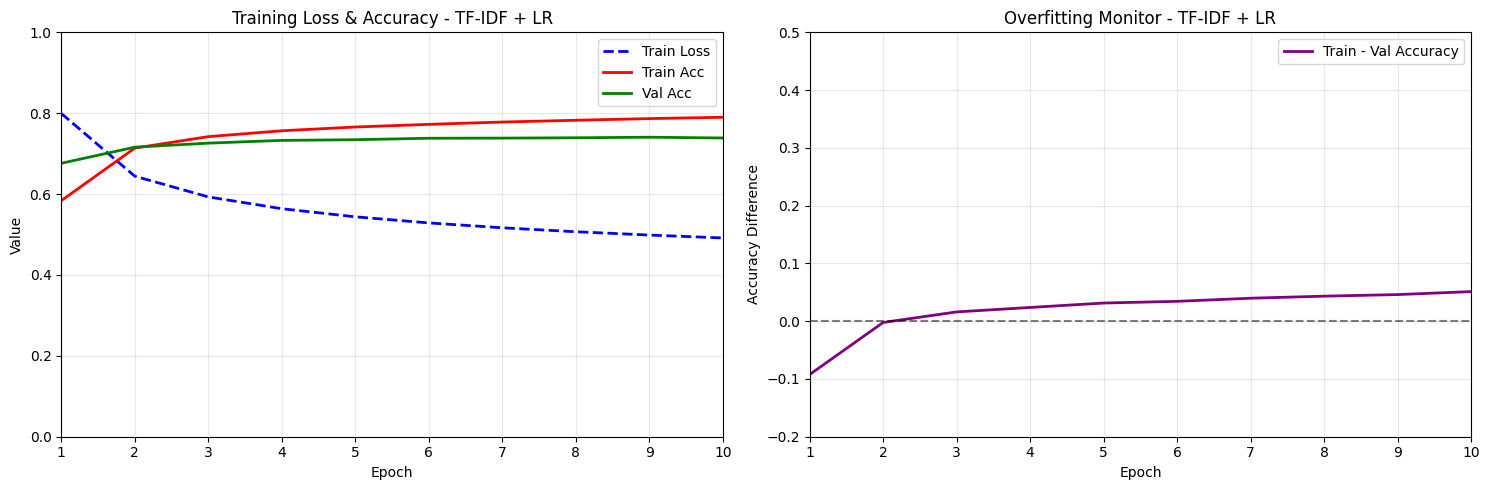


TRAINING SUMMARY
Model Name: TF-IDF + LR
Final Train Loss: 0.4915
Final Train Accuracy: 0.7899
Final Val Loss: 0.5806
Final Val Accuracy: 0.7387
Best Val Accuracy: 0.7406 (Epoch 9)
Final Overfitting Gap: 0.0512


In [16]:
# 绘制训练曲线
plot_training_curves("TF-IDF + LR", logreg_history)

# 打印训练摘要
print_training_summary("TF-IDF + LR", logreg_history)

最后，在测试集上评估模型性能，绘制混淆矩阵，并保存训练结果。

Testing:   0%|          | 0/58486 [00:00<?, ?it/s]


TEST RESULTS
Model Name: TF-IDF + LR
Test Accuracy: 0.7389
Test Precision (weighted): 0.7408
Test Recall (weighted): 0.7389
Test F1 Score (weighted): 0.7356

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8125    0.6928    0.7479     18608
     Neutral     0.6643    0.5908    0.6254     14723
    Positive     0.7325    0.8597    0.7910     25155

    accuracy                         0.7389     58486
   macro avg     0.7364    0.7145    0.7214     58486
weighted avg     0.7408    0.7389    0.7356     58486



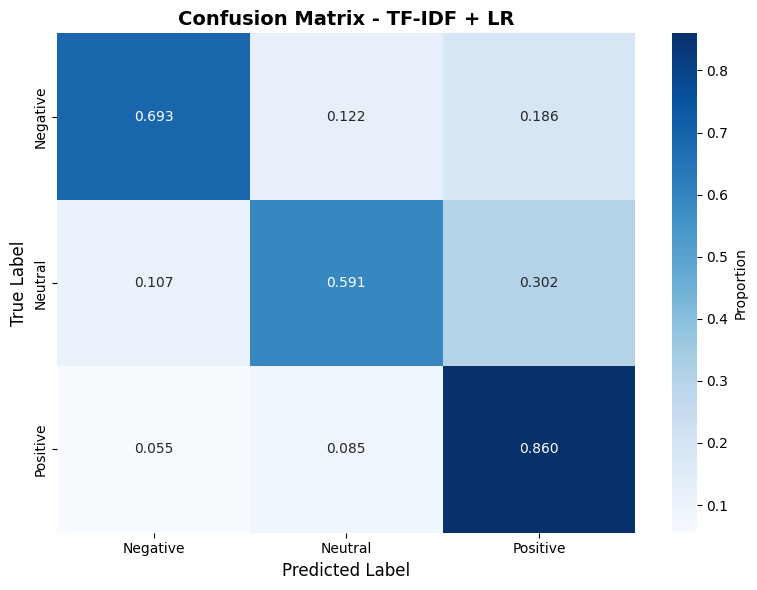


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8125, Recall=0.6928, F1=0.7479, Support=18608
 Neutral: Precision=0.6643, Recall=0.5908, F1=0.6254, Support=14723
Positive: Precision=0.7325, Recall=0.8597, F1=0.7910, Support=25155


In [17]:
logreg_test_results = test_model_comprehensive(
    model=logreg,
    model_name="TF-IDF + LR",
    test_loader=test_data_loader_tfidf,
    device=device,
    target_names=['Negative', 'Neutral', 'Positive']
)

In [18]:
save_training_results(
    model=logreg,
    model_name="TF-IDF + LR",
    set_epochs=num_epoch,
    actual_epochs=len(logreg_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=logreg_history,
    test_results=logreg_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: TF-IDF + LR (LogisticRegression)
  - 实际训练轮数: 10
  - 测试准确率: 0.7389
  - 测试F1分数: 0.7356
  - 记录时间: 2025-11-26 09:56:18
  - 总记录数: 53


## 5.5 多层感知机

上一部分，我们使用多分类逻辑回归模型作为基线模型，取得了不错的效果。

接下来，我们在逻辑回归模型的基础上更进一步，构建一个简单的多层感知机模型，并引入词袋模型。

### 5.5.1 模型原理

回忆一下，多分类逻辑回归的网络模型中，只使用了一个线性层来进行特征变换，然后使用 Softmax 函数将线性输出转换为概率分布。

然而，在现实任务中，数据往往具有复杂的非线性关系，单一的线性变换可能无法充分捕捉这些关系。

为此，我们通过在网络中增加待非线性激活函数的隐藏层，以增强模型的表达能力和学习复杂模式的能力，这就是 **多层感知机**（Multi-layer Perceptron, MLP）模型的核心架构。

例如，我们可以设计如下的多层感知机：
$$
\boldsymbol{z} = \boldsymbol{W}^{[1]}\boldsymbol{x} + \boldsymbol{b}^{[1]}
$$
$$
\boldsymbol{h} = \text{ReLU}(\boldsymbol{z})
$$
$$
\boldsymbol{y} = \boldsymbol{W}^{[2]}\boldsymbol{h} + \boldsymbol{b}^{[2]}
$$
式中，$\boldsymbol{W}^{[i]}$ 和 $\boldsymbol{b}^{[i]}$ 分别表示第 $i$ 层感知机的权重和偏置项；$\text{ReLU}$（Rectified Linear Unit）是一种 **非线性激活函数**，定义为：
$$
\text{ReLU}(x)=\max(0,z)
$$

MLP 的模型架构可由下图表示。

![MLP Architecture](pics\mlp.svg)

值得注意的是，MLP 模型可以解决非线性可分问题，这是逻辑回归模型无法胜任的任务。

我们可以直接使用 PyTorch 框架中已实现的各种激活函数作为隐藏层的函数。

例如，我们将在下面 MLP 模型的实现代码中看到：
```python
from torch.nn import functional as F

class MLP(nn.Module):
    def __init__(self, ..., hidden_dim, ...):
        ...
        self.linear1 = nn.Linear(..., hidden_dim)
        self.activate = F.relu
        self.linear2 = nn.Linear(hidden_dim, ...)
    
    def forward(self, ...):
        ...
        hidden = self.activate(self.linear1(...))
        output = self.linear2(hidden)
        ...
```


### 5.5.2 词向量表示
在上一部分中，我们使用了 TF-IDF 方法将文本转换为特征向量。

回忆一下，TF-IDF 采用基于词频统计的方法，为每个文档（即每个句子）生成高维、稀疏的特征向量。每个句子对应的特征向量是通过对语料库进行统计得到的，一旦确定，向量值就不会改变。

这种方式虽然简单有效、可解释性强，但往往无法捕捉词语之间的语义相似性，且高维、稀疏的特点可能导致模型训练效率低下。

为了解决上述问题，我们引入了 **词向量**（Word Embedding，又称为词嵌入）表示方法，并结合 **词袋**（Bag-of-Words, BoW）模型来表示文本。

词向量表示中，每个词语被映射到一个低维、稠密的向量空间中。

不同于 TF-IDF 所生成的特征向量的向量值不变性，词向量表示可以通过训练不断调整词向量，使其更好地捕捉词语之间的语义关系，例如使得“开心”和“高兴”的词向量在向量空间中更接近。

此时，我们可以将词向量中的向量值视作模型的参数，通过反向传播算法进行优化。

PyTorch 框架提供了 `nn.Embedding` 类来实现词向量表示。

当创建词向量对象时，需要提供两个参数：词表大小（`num_embeddings`）和词向量维度（`embedding_dim`）。

创建词向量对象后，PyTorch 会随机初始化词向量矩阵，矩阵的形状为 `(num_embeddings, embedding_dim)`。在训练过程中，词向量矩阵的值会根据任务的需要进行更新和优化。

例如：

In [19]:
import torch
from torch import nn

embedding = nn.Embedding(8, 3)  # 词表大小为8，词向量维度为3

inputs = torch.tensor([
    [0, 1, 2, 1], 
    [4, 6, 6, 7]
], dtype=torch.long)  # 输入形状为 (2, 4) 的整数向量，每个整数范围是 0~7

outputs = embedding(inputs)  

outputs

tensor([[[ 0.3295,  0.1780,  0.6246],
         [-1.3987,  0.5304, -0.8258],
         [-0.7561,  0.1402, -1.3401],
         [-1.3987,  0.5304, -0.8258]],

        [[ 0.9197, -0.2729,  0.0792],
         [-0.6037,  0.6709, -0.3137],
         [-0.6037,  0.6709, -0.3137],
         [ 0.2290,  0.8000, -0.0507]]], grad_fn=<EmbeddingBackward0>)

如前所述，词向量层需要足够的训练数据来学习合适的词向量。

不过，如果目标任务的训练数据较少，那么学习合适的词向量难度会比较大。

因此，利用自然语言文本所蕴含的自监督学习信号（词与上下文的贡献关系），先预训练词向量，往往会获得更好的结果。

关于预训练词向量的相关内容，我们会在 `06Pre-trained Word Embeddings.ipynb` 中进行详细介绍，并在 `08Comparison and Analysis.ipynb` 中比较使用预训练词向量与随机初始化词向量的同种模型的性能差异。

### 5.5.3 词袋表示

根据多层感知机的实现方式我们知道，模型的输入需要是一个固定长度的向量。

如果输入为文本数据，则需要将文本中的词语（更准确地，词元，关于词元化见 `04Segmentation and Tokenization.ipynb`）通过上述的词向量方式转换为向量表示。

但是，一个句子通常含有多个词元，如何将多个词元的词向量合并为一个固定长度的向量呢？

这里，我们使用 **词袋**（Bag-of-Words, BoW）模型来实现这一目标。

词袋模型的核心思想是：表示一个句子时，不考虑其中词元的顺序，仅将其简单地视为一个集合。

于是就可以采用聚合操作处理一个句子中的所有词元的词向量，得到一个固定长度的向量表示。

In [20]:
print(outputs)

emb_agg = outputs.mean(dim=1)  # 在序列长度维度上取平均

emb_agg

tensor([[[ 0.3295,  0.1780,  0.6246],
         [-1.3987,  0.5304, -0.8258],
         [-0.7561,  0.1402, -1.3401],
         [-1.3987,  0.5304, -0.8258]],

        [[ 0.9197, -0.2729,  0.0792],
         [-0.6037,  0.6709, -0.3137],
         [-0.6037,  0.6709, -0.3137],
         [ 0.2290,  0.8000, -0.0507]]], grad_fn=<EmbeddingBackward0>)


tensor([[-0.8060,  0.3448, -0.5918],
        [-0.0147,  0.4672, -0.1497]], grad_fn=<MeanBackward1>)

然而，更实际的自然语言处理任务中，一个批次里输入的文本长度往往是不固定的，因此无法像上面的代码一样简单地用一个张量存储词向量并求平均值。

PyTorch 提供了一种更灵活的解决方案，即 EmbeddingBag 层。

在调用 EmbeddingBag 层时，首先需要将不定长的序列拼接起来，然后用一个偏移向量（`offsets`）记录每个序列的起始位置。

EmbeddingBag 层会根据偏移向量自动将拼接后的序列划分为多个子序列，并对每个子序列的词向量进行聚合操作（如求和或求平均），从而得到每个句子的固定长度向量表示。

例如：

In [21]:
input1 = torch.tensor([0, 1, 2, 1], dtype=torch.long)
input2 = torch.tensor([2, 1, 3, 7, 6], dtype=torch.long)
input3 = torch.tensor([6, 4, 2], dtype=torch.long)
input4 = torch.tensor([4, 6, 6, 7, 5, 2], dtype=torch.long)

inputs = [input1, input2, input3, input4]

offsets = [0] + [i.shape[0] for i in inputs]

print(f"offsets before cumsum: {offsets}")

offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

print(f"offsets after cumsum: {offsets}")

inputs = torch.cat(inputs)

print(f"inputs after cat: {inputs}")

embeddingbag = nn.EmbeddingBag(num_embeddings=8, embedding_dim=3)
embeddings = embeddingbag(inputs, offsets)  # 输出形状为 (4, 3)
print(embeddings)

offsets before cumsum: [0, 4, 5, 3, 6]
offsets after cumsum: tensor([ 0,  4,  9, 12])
inputs after cat: tensor([0, 1, 2, 1, 2, 1, 3, 7, 6, 6, 4, 2, 4, 6, 6, 7, 5, 2])
tensor([[-0.6343,  0.0415, -0.5786],
        [-0.0162,  0.4970,  0.0452],
        [ 0.3283,  0.1781,  0.1753],
        [ 0.2851,  0.8465, -0.3518]], grad_fn=<EmbeddingBagBackward0>)


### 5.5.4 数据集与加载器构建

为了将数据转换为便于 PyTorch 使用的形式，我们同样需要定义数据适配器和数据加载器。

数据适配器 `BowDataset` 的定义是简单的，这是因为我们事先已经做好了文本的分词与向量化处理。

适配器名称中的 `Bow` 是词袋的意思。

In [ ]:
from torch.utils.data import Dataset

class BowDataset(Dataset):  #@save
    def __init__(self, data: DataFrame) -> None:
        self.data = data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, i: int):
        return self.data.iloc[i]
    

# 加载数据
train_dataset = BowDataset(train_idx)
val_dataset = BowDataset(val_idx)
test_dataset = BowDataset(test_idx)

构建数据加载器时，不同于逻辑回归，对于输入的每一个数据批次，我们需要按照上面提到的 `nn.EmbeddingBag` 的要求，构建拼接后的词元索引张量 `inputs` 和偏移向量 `offsets`。

这相当于对输入数据批次的形式进行整理，其逻辑可以定义成为一个整理函数，在数据加载器中作为 `collate_fn` 参数传入。

In [46]:
from torch.utils.data import DataLoader

def collate_fn_mlp(batch):  #@save
    # 从独立样本集合中构建各批次的输入输出
    # 其中 BowDataset 类定义了一个样本的数据结构，即输入标签和输出标签的元组
    # 因此，将输入 inputs 定义为一个张量的列表，其中每个张量为原始句子中词元序列对应的索引值序列
    inputs = [torch.tensor(b["text"]) for b in batch]

    # 输出的目标 targets 为该批次中由全部样例输出结果构成的张量
    targets = torch.tensor([b["label"] for b in batch], dtype=torch.long)

    # 获取一个批次中每个样例的序列长度
    offsets = [0] + [i.shape[0] for i in inputs]

    # 根据序列的长度，转换为每个序列起始位置的偏移量
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    # 将 inputs 列表中的张量拼接成一个大的张量
    inputs = torch.cat(inputs)

    return inputs, offsets, targets


train_data_loader_mlp = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=True)
val_data_loader_mlp = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=False)
test_data_loader_mlp = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_mlp, shuffle=False)

### 5.5.5 模型构建

完成相关准备工作后，我们就可以开始搭建 MLP模型了。

MLP 的基本架构已在前面的部分提及，相对简单。

下面的代码中，构造方法的参数 `pretrained_embedding_matrix` 的作用是提供初始化词向量矩阵的预训练词向量，我们会在 `06Pre-train Word Embedding.ipynb` 中使用这个参数。

在本 Notebook 中，我们不提供该参数，PyTorch 就会使用随机初始化的词向量。

在神经网络架构方面，除已提及的词嵌入层、线性层和隐藏层外，我们还引入了 Dropout 层，以进一步防止模型过拟合。

Dropout 层通过在训练过程中随机“丢弃”一部分神经元，减少神经元之间的复杂共适应关系，从而提高模型的泛化能力。

In [47]:
from torch.nn import functional as F

class MLP(nn.Module):  #@save
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_class, 
                 pretrained_embedding_matrix=None, freeze=True):
        super(MLP, self).__init__()

        # EmbeddingBag 层
        if pretrained_embedding_matrix is not None:
            self.embeddingbag = nn.EmbeddingBag.from_pretrained(pretrained_embedding_matrix, freeze=freeze, mode="mean")
        else:
            self.embeddingbag = nn.EmbeddingBag(vocab_size, embedding_dim)


        # 线性变换：词向量层 -> 隐含层
        self.linear1 = nn.Linear(embedding_dim, hidden_dim)

        # 使用ReLU激活函数
        self.activate = F.relu

        # 线性变换：激活层 -> 输出层
        self.linear2 = nn.Linear(hidden_dim, num_class)

        self.dropout = nn.Dropout(0.5)
    
    def forward(self, inputs, offsets):
        embedding = self.embeddingbag(inputs, offsets)
        hidden = self.activate(self.linear1(embedding))
        hidden = self.dropout(hidden)
        outputs = self.linear2(hidden)
        return outputs

### 5.5.6 模型训练与测试

最后，我们可以开始训练 MLP 模型了。

在超参数设置上，我们将嵌入维度 `embedding_dim` 设为 `200`，这是为了与后续实验中使用的预训练词向量维度保持一致，便于比较。

In [ ]:
# 超参数设置
embedding_dim = 200
num_class = 3
hidden_dim = 256
batch_size = 32
num_epoch = 10

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp = MLP(len(vocab), embedding_dim, hidden_dim, num_class)
mlp.to(device)

weights = class_weights(train_idx)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

In [26]:
# 使用通用训练函数
mlp_history = train_model_with_validation(
    model=mlp,
    train_loader=train_data_loader_mlp,
    val_loader=val_data_loader_mlp,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device,
)

Training Epoch 1:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 1/10
    Train Loss: 0.7101	Train Accuracy: 0.6706
    Valid Loss: 0.6215	Valid Accuracy: 0.7216
    Valid Precision: 0.7211	Valid Recall: 0.7216	Valid F1: 0.7169
    ✓ New best validation loss: 0.6215
--------------------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 2/10
    Train Loss: 0.5831	Train Accuracy: 0.7445
    Valid Loss: 0.5996	Valid Accuracy: 0.7409
    Valid Precision: 0.7379	Valid Recall: 0.7409	Valid F1: 0.7373
    ✓ New best validation loss: 0.5996
--------------------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 3/10
    Train Loss: 0.5380	Train Accuracy: 0.7680
    Valid Loss: 0.5957	Valid Accuracy: 0.7382
    Valid Precision: 0.7369	Valid Recall: 0.7382	Valid F1: 0.7316
    ✓ New best validation loss: 0.5957
--------------------------------------------------------------------------------


Training Epoch 4:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 4/10
    Train Loss: 0.5085	Train Accuracy: 0.7821
    Valid Loss: 0.5999	Valid Accuracy: 0.7397
    Valid Precision: 0.7400	Valid Recall: 0.7397	Valid F1: 0.7349
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 5:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 5/10
    Train Loss: 0.4849	Train Accuracy: 0.7930
    Valid Loss: 0.6202	Valid Accuracy: 0.7392
    Valid Precision: 0.7403	Valid Recall: 0.7392	Valid F1: 0.7308
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 6:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 6/10
    Train Loss: 0.4639	Train Accuracy: 0.8025
    Valid Loss: 0.6175	Valid Accuracy: 0.7406
    Valid Precision: 0.7410	Valid Recall: 0.7406	Valid F1: 0.7354
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5957


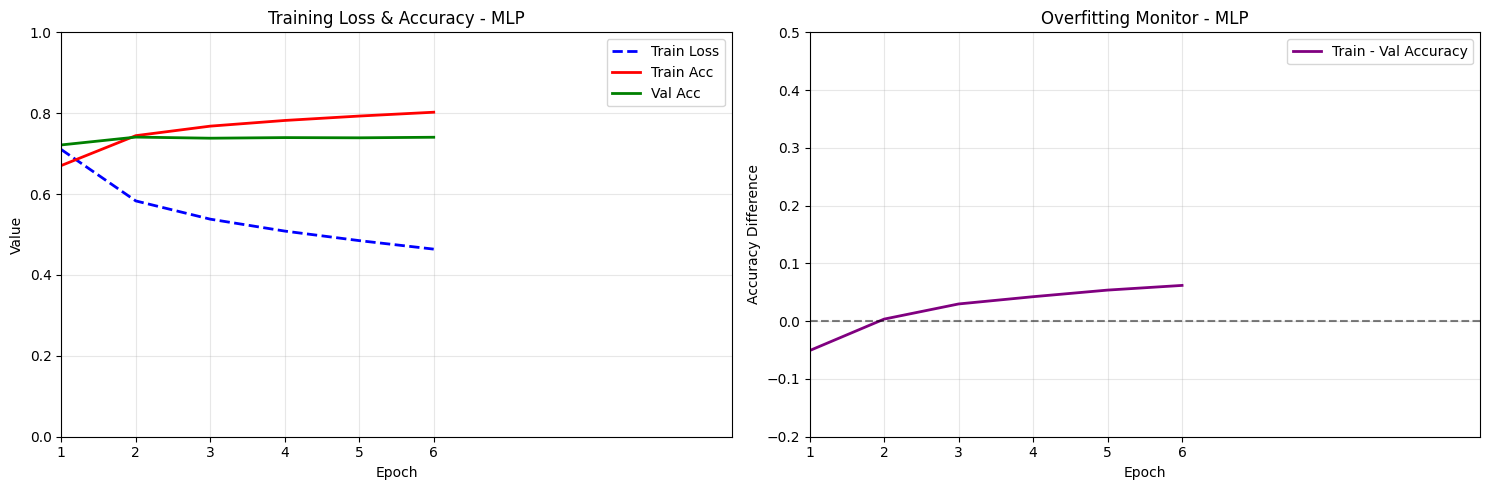


TRAINING SUMMARY
Model Name: MLP
Final Train Loss: 0.4639
Final Train Accuracy: 0.8025
Final Val Loss: 0.6175
Final Val Accuracy: 0.7406
Best Val Accuracy: 0.7409 (Epoch 2)
Final Overfitting Gap: 0.0619


In [27]:
# 绘制训练曲线
plot_training_curves("MLP", mlp_history)

# 打印训练摘要
print_training_summary("MLP", mlp_history)

Testing:   0%|          | 0/58486 [00:00<?, ?it/s]


TEST RESULTS
Model Name: MLP
Test Accuracy: 0.7407
Test Precision (weighted): 0.7396
Test Recall (weighted): 0.7407
Test F1 Score (weighted): 0.7346

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7720    0.7503    0.7610     18608
     Neutral     0.7098    0.5268    0.6048     14723
    Positive     0.7330    0.8589    0.7910     25155

    accuracy                         0.7407     58486
   macro avg     0.7383    0.7120    0.7189     58486
weighted avg     0.7396    0.7407    0.7346     58486



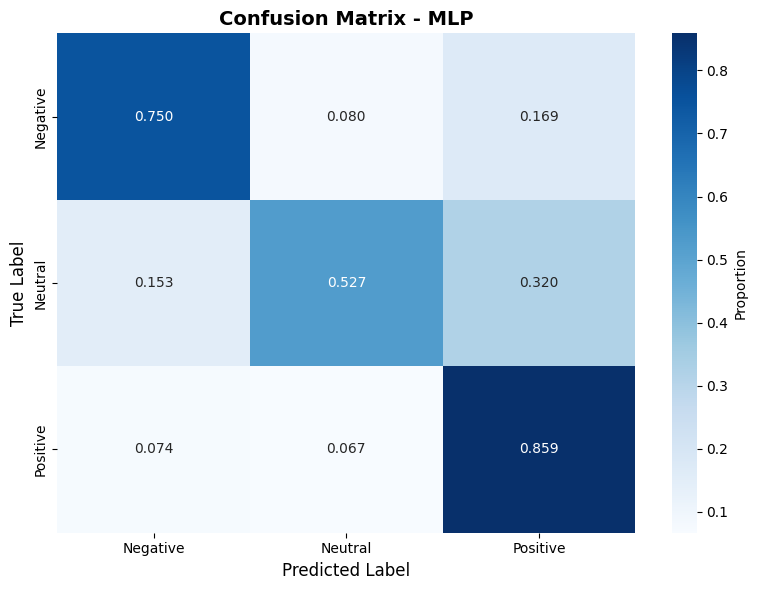


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7720, Recall=0.7503, F1=0.7610, Support=18608
 Neutral: Precision=0.7098, Recall=0.5268, F1=0.6048, Support=14723
Positive: Precision=0.7330, Recall=0.8589, F1=0.7910, Support=25155


In [28]:
# MLP 测试过程 - 使用通用框架
mlp_test_results = test_model_comprehensive(
    model=mlp,
    model_name="MLP",
    test_loader=test_data_loader_mlp,
    device=device,
)

In [29]:
# 保存MLP训练结果
save_training_results(
    model=mlp,
    model_name="MLP",
    set_epochs=num_epoch,
    actual_epochs=len(mlp_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=mlp_history,
    test_results=mlp_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: MLP (MLP)
  - 实际训练轮数: 6
  - 测试准确率: 0.7407
  - 测试F1分数: 0.7346
  - 记录时间: 2025-11-26 10:00:59
  - 总记录数: 54


## 5.6 卷积神经网络

俗话说：“卷卷卷，天天就知道卷，你卷泥马呢。”

在深度学习领域，“卷”也是一种非常重要的操作，最有代表性的模型就是卷积神经网络。

### 5.6.1 模型原理

在上面实现的 MLP 模型中，每层输入的各元素需要乘以一个独立的权重。

然而，对于文本情感分类任务，这样做可能并不合适，因为句子的情感极性往往由个别词或短语决定，而这些决定性的词或短语在句子中的位置并不固定，若仅使用全连接层（或称为稠密层），模型难以捕捉到这些局部特征。

为了解决以上问题，一个非常直接的想法是使用一个小的稠密层，在句子中滑动，以捕捉局部特征。该操作又被称为 **卷积**（Convolution）操作，其中每个小的、用于提取局部特征的稠密层又被称为 **卷积核**（Convolution Kernel）或 **滤波器**（Filter）。

![1D Convolution](pics\conv1d.svg)

卷积操作输出的结果还可以进一步聚合，这一过程称为 **池化**（Pooling）操作。常用的池化操作有最大池化、平均池化等。

以最大池化为例，其含义是仅保留最有意义的局部特征。如在情感分类任务中，保留的是句子中对于分类最关键的 N-gram 信息。

下图展示了 2 维最大池化的示意图：

![Pooling](pics\pooling.svg)

在进行卷积操作时，还可以使用多个卷积核提取不同种类的局部特征。

卷积核的构造方式大致有两种，一种是使用不同组的参数，并使用不同的初始化参数，获得不同的卷积核；另一种是提取不同尺度的局部特征，如提取不同大小的 N-gram。

多个卷积核会输出多个特征，为了衡量各个特征对最终分类结果的贡献，只需要再经过一个全连接的分类层就可以做出最终的决策。

最后，还可以将多个卷积层加池化层堆叠起来，形成更深层的网络，这些网络统称为 **卷积神经网络**（Convolutional Neural Network, CNN）。

上面针对文本等序列数据的卷积操作只沿单一方向滑动，称为 **一维卷积**。

而对于图像等数据，则需要在二维空间内滑动，称为二维卷积。类似的还有三维卷积。

实际上，卷积神经网络最初是为图像处理任务设计的，后来才被广泛应用于各种任务中，包括文本分类任务。

由于二维及以上的卷积操作在自然语言处理中并不常用，因此在这里不做过多介绍。

### 5.6.2 卷积操作实现

PyTorch 中提供了 `nn.Conv1d` 类来实现一维卷积操作，其构造函数至少需要提供三个参数：`in_channels` 为输入通道的个数，在输入层对应词向量的维度；`out_channels` 为输出通道的个数，对应卷积核的个数；`kernel_size` 为每个卷积核的宽度

当调用该 `Conv1d` 对象时，输入数据形状为 `(batch, in_channels, seq_len)`，输出数据形状为 `(batch, out_channels, seq_len)`，其中在输入数据和输出数据中，`seq_len` 分别表示输入序列和输出序列的长度。

In [30]:
import torch
from torch.nn import Conv1d

# 定义一个一维卷积，输入通道大小为5，输出通道大小为2，卷积核宽度为4
conv1 = Conv1d(5, 2, 4)

# 再定义一个一维卷积，输入通道大小为5，输出通道大小为2，卷积核宽度为3
conv2 = Conv1d(5, 2, 3)

# 输入数据批次大小为2，即有两个序列，每个序列的长度为6，每个输入的维度为5
inputs = torch.rand(2, 5, 6)

# 通过第一个卷积层
outputs1 = conv1(inputs)

# 通过第二个卷积层
outputs2 = conv2(inputs)

print(f"outputs1: \n{outputs1}")
print(f"outputs2: \n{outputs2}")

outputs1: 
tensor([[[ 0.2996, -0.3020, -0.2760],
         [ 0.2879,  0.4439,  0.0245]],

        [[-0.0888, -0.1245, -0.0842],
         [ 0.7789,  0.5687,  0.3657]]], grad_fn=<ConvolutionBackward0>)
outputs2: 
tensor([[[-0.0305,  0.0692,  0.2472,  0.3190],
         [-0.0928, -0.1753, -0.5100, -0.4579]],

        [[ 0.0280,  0.0914,  0.2013,  0.0209],
         [-0.4558, -0.5121, -0.4597, -0.2708]]],
       grad_fn=<ConvolutionBackward0>)


接下来需要调用池化层类。

`torch.nn` 模块中提供了多种池化层的实现，例如 `nn.MaxPool1d` 实现了一维最大池化操作，其构造函数至少需要提供一个参数 `kernel_size`，表示池化窗口的大小，也就是对多大范围内的输入进行聚合。

如果对整个输入序列进行池化操作，则其大小应为卷积层输出的序列长度。

In [31]:
from torch.nn import MaxPool1d

pool1 = MaxPool1d(3)  # 池化核宽度为3，即卷积层的输出序列长度
pool2 = MaxPool1d(4)  # 池化核宽度为4

outputs_pool1 = pool1(outputs1)  # 执行一维最大池化操作，即取每行输入的最大值
output2_pool2 = pool2(outputs2)

print(f"outputs_pool1: \n{outputs_pool1}")
print(f"output2_pool2: \n{output2_pool2}")

outputs_pool1: 
tensor([[[ 0.2996],
         [ 0.4439]],

        [[-0.0842],
         [ 0.7789]]], grad_fn=<SqueezeBackward1>)
output2_pool2: 
tensor([[[ 0.3190],
         [-0.0928]],

        [[ 0.2013],
         [-0.2708]]], grad_fn=<SqueezeBackward1>)


除了使用池化层对象实现池化，PyTorch 还在 `torch.nn.functional` 中实现了池化函数，如 `max_pool1d` 等，即无需定义一个池化层对象就可以直接调用池化功能。

这两种实现方法基本一致，一个显著的区别在于使用池化函数时无须实现指定池化层核的大小，只要在调用时提供即可。

当处理不定长度的序列时，这种实现方法更加适合。

In [32]:
import torch.nn.functional as F

outputs_pool1 = F.max_pool1d(outputs1, kernel_size=outputs1.shape[2])  # 池化核宽度等于序列长度
output2_pool2 = F.max_pool1d(outputs2, kernel_size=outputs2.shape[2])

print(f"outputs_pool1: \n{outputs_pool1}")
print(f"output2_pool2: \n{output2_pool2}")

outputs_pool1: 
tensor([[[ 0.2996],
         [ 0.4439]],

        [[-0.0842],
         [ 0.7789]]], grad_fn=<SqueezeBackward1>)
output2_pool2: 
tensor([[[ 0.3190],
         [-0.0928]],

        [[ 0.2013],
         [-0.2708]]], grad_fn=<SqueezeBackward1>)


由于 `outputs_pool1` 和 `outputs_pool2` 是两个独立的张量，为了执行下一步操作，还需要调用 `torch.cat` 函数将它们拼接起来。

在此之前，还需要调用 `squeeze` 函数，将最后一个为 $1$ 的维度删除，即将 $2$ 行 $1$ 列的张量转换为 $1$ 个向量。

In [33]:
outputs_pool_squeeze1 = outputs_pool1.squeeze(dim=2)
output2_pool_squeeze2 = output2_pool2.squeeze(dim=2)

print(f"outputs_pool_squeeze1: \n{outputs_pool_squeeze1}")
print(f"output2_pool_squeeze2: \n{output2_pool_squeeze2}")

outputs_pool = torch.cat([outputs_pool_squeeze1, output2_pool_squeeze2], dim=1)  # 在特征维度上拼接

print(f"outputs_pool: \n{outputs_pool}")

outputs_pool_squeeze1: 
tensor([[ 0.2996,  0.4439],
        [-0.0842,  0.7789]], grad_fn=<SqueezeBackward1>)
output2_pool_squeeze2: 
tensor([[ 0.3190, -0.0928],
        [ 0.2013, -0.2708]], grad_fn=<SqueezeBackward1>)
outputs_pool: 
tensor([[ 0.2996,  0.4439,  0.3190, -0.0928],
        [-0.0842,  0.7789,  0.2013, -0.2708]], grad_fn=<CatBackward0>)


最后再连接一个全连接层，实现分类功能。

In [34]:
from torch.nn import Linear

linear = Linear(4, 2)
outputs_linear = linear(outputs_pool)
print(f"outputs_linear: \n{outputs_linear}")

outputs_linear: 
tensor([[-0.4366,  0.0372],
        [-0.5197, -0.2172]], grad_fn=<AddmmBackward0>)


### 5.6.3 模型构建

CNN 模型的搭建与 MLP 是类似的，区别主要在于添加了卷积层和池化层。

此外，在调用 CNN 时，还需要设置两个额外的超参数，分别为 `filter_size` 表示卷积核的大小，以及 `num_filters` 表示卷积核的个数。

In [35]:
class CNN(nn.Module):  #@save
    def __init__(self, vocab_size, embedding_dim, filter_size, num_filter, num_class,
                 pretrained_embedding_matrix=None, freeze=True) -> None:
        super(CNN, self).__init__()
        if pretrained_embedding_matrix:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding_matrix, freeze=freeze)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d = nn.Conv1d(embedding_dim, num_filter, filter_size, padding=1)  # padding=1 表示在卷积操作之前，将序列的前后各补充1个输入
        self.dropout = nn.Dropout(0.5)
        self.activate = F.relu
        self.linear = nn.Linear(num_filter, num_class)

    
    def forward(self, inputs):
        embedding = self.embedding(inputs)
        convolution = self.activate(self.conv1d(embedding.permute(0, 2, 1)))
        convolution = self.dropout(convolution)
        pooling = F.max_pool1d(convolution, kernel_size=convolution.shape[2])
        outputs = self.linear(pooling.squeeze(dim=2))
        return outputs

另外，也需要对数据整理函数进行一些修改。

由于在 CNN 模型，我们不再使用词袋模型，换言之，我们将考虑词元之间的顺序关系，因此在数据整理函数中，我们不需要对词元进行拼接，而是直接将每个句子的词元索引列表转换为张量格式，并且为了保持张量形状统一，需要对同一批次中的张量使用 **补齐**（Padding）。

代码中，`pad_sequence` 函数实现补齐功能，使一个批次中全部序列长度相同，同最大长度序列，不足的默认用 `0` 补齐。

In [36]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn_cnn(batch):
    inputs = [torch.tensor(b["text"]) for b in batch]
    targets = torch.tensor([b["label"] for b in batch], dtype=torch.long)

    # 对批次内的样本补齐，使其具有相同的长度
    inputs = pad_sequence(inputs, batch_first=True)
    return inputs, targets

In [ ]:
train_data_loader_cnn = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=True)
val_data_loader_cnn = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=False)
test_data_loader_cnn = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_cnn, shuffle=False)

# CNN 相关参数
filter_size = 3
num_filter = 100

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn = CNN(len(vocab), embedding_dim, filter_size, num_filter, num_class)
cnn.to(device)

weights = class_weights(train_idx)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

CNN(
  (embedding): Embedding(39768, 200)
  (conv1d): Conv1d(200, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=100, out_features=3, bias=True)
)

### 5.6.4 模型训练与测试

做好前置工作后，我们就可以开始训练 CNN 模型了。

In [ ]:
# 使用通用训练函数
cnn_history = train_model_with_validation(
    model=cnn,
    train_loader=train_data_loader_cnn,
    val_loader=val_data_loader_cnn,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 1/10
    Train Loss: 0.7204	Train Accuracy: 0.6633
    Valid Loss: 0.6552	Valid Accuracy: 0.7248
    Valid Precision: 0.7217	Valid Recall: 0.7248	Valid F1: 0.7194
    ✓ New best validation loss: 0.6552
--------------------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 2/10
    Train Loss: 0.5979	Train Accuracy: 0.7354
    Valid Loss: 0.6310	Valid Accuracy: 0.7337
    Valid Precision: 0.7413	Valid Recall: 0.7337	Valid F1: 0.7353
    ✓ New best validation loss: 0.6310
--------------------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 3/10
    Train Loss: 0.5518	Train Accuracy: 0.7607
    Valid Loss: 0.6086	Valid Accuracy: 0.7231
    Valid Precision: 0.7383	Valid Recall: 0.7231	Valid F1: 0.7208
    ✓ New best validation loss: 0.6086
--------------------------------------------------------------------------------


Training Epoch 4:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 4/10
    Train Loss: 0.5194	Train Accuracy: 0.7772
    Valid Loss: 0.5880	Valid Accuracy: 0.7447
    Valid Precision: 0.7444	Valid Recall: 0.7447	Valid F1: 0.7420
    ✓ New best validation loss: 0.5880
--------------------------------------------------------------------------------


Training Epoch 5:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 5/10
    Train Loss: 0.4937	Train Accuracy: 0.7903
    Valid Loss: 0.6003	Valid Accuracy: 0.7216
    Valid Precision: 0.7386	Valid Recall: 0.7216	Valid F1: 0.7176
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 6:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 6/10
    Train Loss: 0.4722	Train Accuracy: 0.8007
    Valid Loss: 0.6036	Valid Accuracy: 0.7306
    Valid Precision: 0.7455	Valid Recall: 0.7306	Valid F1: 0.7314
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 7:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 7/10
    Train Loss: 0.4506	Train Accuracy: 0.8111
    Valid Loss: 0.6094	Valid Accuracy: 0.7314
    Valid Precision: 0.7464	Valid Recall: 0.7314	Valid F1: 0.7339
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5880


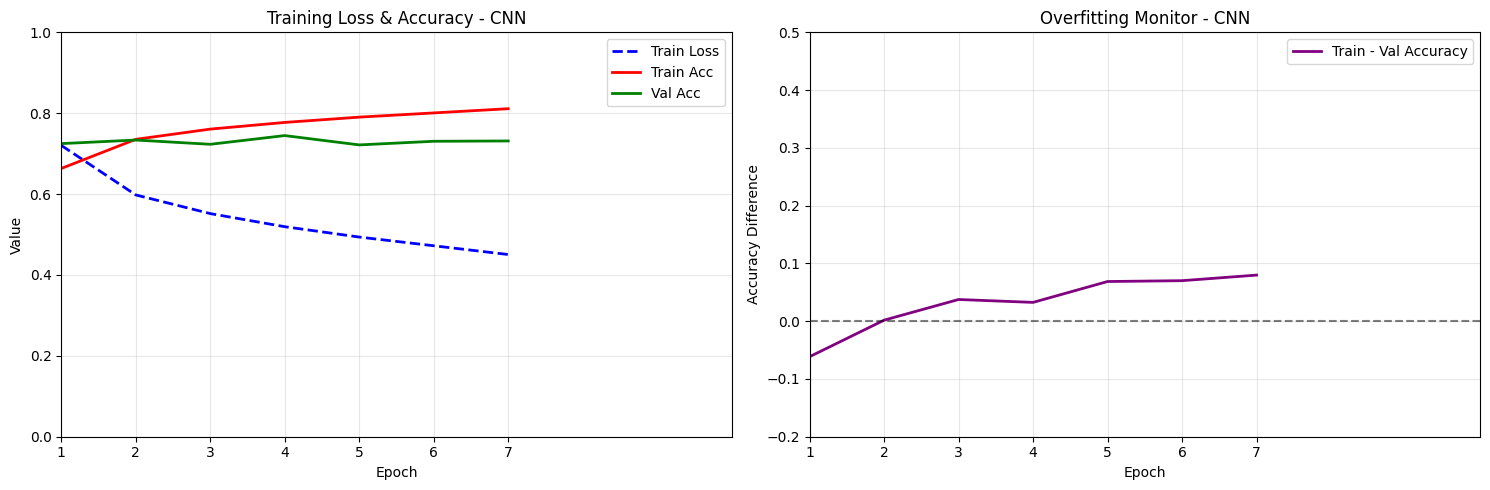


TRAINING SUMMARY
Model Name: CNN
Final Train Loss: 0.4506
Final Train Accuracy: 0.8111
Final Val Loss: 0.6094
Final Val Accuracy: 0.7314
Best Val Accuracy: 0.7447 (Epoch 4)
Final Overfitting Gap: 0.0798


In [39]:
# 绘制训练曲线
plot_training_curves("CNN", cnn_history)

# 打印训练摘要
print_training_summary("CNN", cnn_history)

Testing:   0%|          | 0/58486 [00:00<?, ?it/s]


TEST RESULTS
Model Name: CNN
Test Accuracy: 0.7417
Test Precision (weighted): 0.7401
Test Recall (weighted): 0.7417
Test F1 Score (weighted): 0.7382

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7904    0.7295    0.7588     18608
     Neutral     0.6693    0.5752    0.6187     14723
    Positive     0.7444    0.8481    0.7929     25155

    accuracy                         0.7417     58486
   macro avg     0.7347    0.7176    0.7234     58486
weighted avg     0.7401    0.7417    0.7382     58486



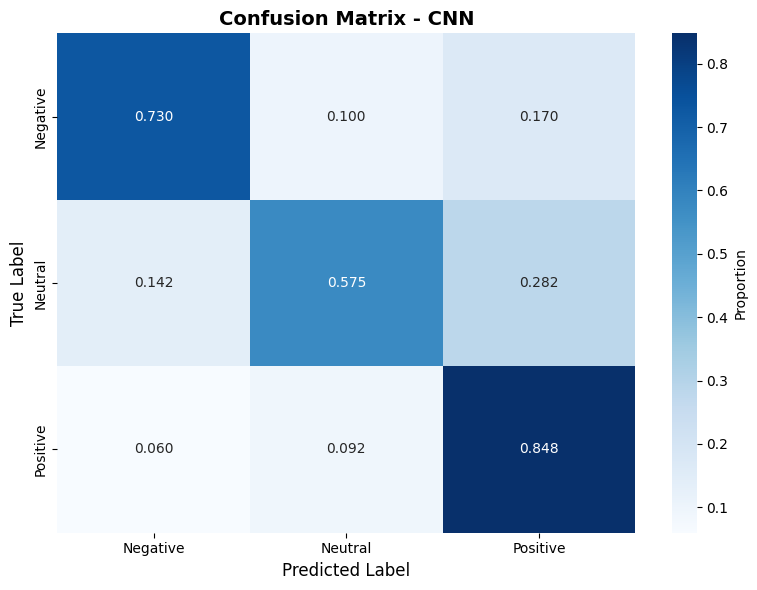


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7904, Recall=0.7295, F1=0.7588, Support=18608
 Neutral: Precision=0.6693, Recall=0.5752, F1=0.6187, Support=14723
Positive: Precision=0.7444, Recall=0.8481, F1=0.7929, Support=25155


In [40]:
# CNN 测试过程 - 使用通用框架
cnn_test_results = test_model_comprehensive(
    model=cnn,
    model_name="CNN",
    test_loader=test_data_loader_cnn,
    device=device
)

In [41]:
# 保存CNN训练结果
save_training_results(
    model=cnn,
    model_name="CNN",
    set_epochs=num_epoch,
    actual_epochs=len(cnn_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=cnn_history,
    test_results=cnn_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: CNN (CNN)
  - 实际训练轮数: 7
  - 测试准确率: 0.7417
  - 测试F1分数: 0.7382
  - 记录时间: 2025-11-26 10:06:45
  - 总记录数: 55


## 5.7 长短时记忆网络

目前为止我们实现的模型，无论是逻辑回归、多层感知机还是卷积神经网络，神经网络中信息都是从输入层经过若干隐含层（如果有），最终传递到输出层，按照一个方向流动，因此它们都被称为 **前馈神经网络**（Feed-Forward Neural Network, FFNN）。

然而，在处理序列数据时，前馈神经网络存在一个显著的缺点，即无法有效地捕捉序列中的时间依赖关系。

为了解决这一问题，我们介绍自然语言处理领域中常用的神经网络——循环神经网络。

### 5.7.1 模型原理

循环神经网络（Recurrent Neural Network, RNN）指的是网络的隐含层输出同时作为自身的输入。

当使用 RNN 处理一个序列输入时，需要将 RNN 按输入时刻展开，然后将序列中的每个输入依次对应到网络不同时刻的输入上，并将当前时刻网络隐含层的输出也作为下一时刻的输入。

按时刻展开的 RNN 网络可以使用如下公式描述：
$$
\boldsymbol{h}_t = \tanh(\boldsymbol{W}^{\mathrm{xh}}\boldsymbol{x}_t + \boldsymbol{b}^{\mathrm{xh}} + \boldsymbol{W}^{\mathrm{hh}}\boldsymbol{h}_{t-1} + \boldsymbol{b}^{\mathrm{hh}})
$$
$$
\boldsymbol{y} = \text{Softmax}(\boldsymbol{W}^{\mathrm{hy}}\boldsymbol{h}_n + \boldsymbol{b}^{\mathrm{hy}})
$$

式中，$\tanh(z) = (\mathrm{e}^z - \mathrm{e}^{-z}) / (\mathrm{e}^z + \mathrm{e}^{-z})$ 表示激活函数，值域为 $(-1, 1)$；$n$ 表示序列长度；$t$ 表示输入序列的当前时刻，其隐含层 $\boldsymbol{h}_t$ 不但与当前的输入 $\boldsymbol{x}_t$ 有关，还与上一时刻的隐含层 $\boldsymbol{h}_{t-1}$ 有关，这实际上是一种递归形式的定义。

每个时刻的输入经过层层递归，对最终的输出产生一定影响，每个时刻的隐含层 $\boldsymbol{h}_t$ 承载了 $1 \sim t$ 时刻的全部输入信息，因此 RNN 中的隐含层也被称作 **记忆单元**（Memory Cell）。

RNN 的网络架构如下图所示：

![RNN Architecture](pics/rnn.jpg)

上述的原始的 RNN 架构中，信息是经过多个隐含层被逐层传递到输出层的，这不可避免地会导致信息的损失，使得网络参数难以优化。

为了解决上述问题，我们介绍 **长短时记忆网络**（Long Short-Term Memory, LSTM）。下面直接给出 LSTM 的相关公式：
$$
\boldsymbol{u}_t = \tanh(\boldsymbol{W}^{\mathrm{xh}}\boldsymbol{x}_t + \boldsymbol{b}^{\mathrm{xh}} + \boldsymbol{W}^{\mathrm{hh}}\boldsymbol{h}_{t-1} + \boldsymbol{b}^{\mathrm{hh}})
$$
$$
\boldsymbol{i}_t = \sigma(\boldsymbol{W}^{\mathrm{i,xh}}\boldsymbol{x}_t + \boldsymbol{b}^{\mathrm{i,xh}} + \boldsymbol{W}^{\mathrm{i,hh}}\boldsymbol{h}_{t-1} + \boldsymbol{b}^{\mathrm{i,hh}})
$$
$$
\boldsymbol{f}_t = \sigma(\boldsymbol{W}^{\mathrm{f,xh}}\boldsymbol{x}_t + \boldsymbol{b}^{\mathrm{f,xh}} + \boldsymbol{W}^{\mathrm{f,hh}}\boldsymbol{h}_{t-1} + \boldsymbol{b}^{\mathrm{f,hh}})
$$
$$
\boldsymbol{h}_t = \boldsymbol{i}_t \odot \boldsymbol{u}_t + \boldsymbol{f}_t \odot \boldsymbol{h}_{t-1}
$$


- $\boldsymbol{u}_t$ 叫做 **候选记忆单元**（Candidate Memory Cell），它表示当前时刻根据输入和上一时刻隐含层计算得到的新的记忆信息
- $\boldsymbol{i}_t$ 叫做 **输入门**（Input Gate），它控制着当前时刻的候选记忆单元 $\boldsymbol{u}_t$ 有多少信息被写入到最终的记忆单元 $\boldsymbol{h}_t$ 中
- $\boldsymbol{f}_t$ 叫做 **遗忘门**（Forget Gate），它控制着上一时刻的记忆单元 $\boldsymbol{h}_{t-1}$ 有多少信息被保留到当前时刻的记忆单元 $\boldsymbol{h}_t$ 中
- $\odot$ 表示 **Hardamard 积**，即按张量对应元素相乘操作
- $\sigma(z) = 1 / (1 + \mathrm{e}^{-z})$ 表示 Sigmoid 激活函数，值域为 $(0, 1)$。

LSTM 的网络架构如下图所示：

![LSTM Architecture](pics/lstm.svg)

### 5.7.2 模型实现

RNN 以及 LSTM 在 PyTorch 的 `torch.nn` 模块中均有实现，分别为 `nn.RNN` 和 `nn.LSTM` 类。这里我们仅介绍 LSTM 的使用方法。

LSTM 的构造函数至少需要提供两个参数：`input_size` 表示每个时刻输入的大小，`hidden_size` 表示隐含层的大小。

另外，根据习惯，通常将 `batch_first` 参数设置为 `True`，这样输入数据的形状为 `(batch, seq_len, input_size)`。

输出数据共有三个，分别为隐含层序列、最后时刻的隐含层状态 `hn` 和最后时刻的记忆单元状态 `cn`。隐含层序列的形状为 `(batch, seq_len, hidden_size)`，`hn` 和 `cn` 的形状均为 `(1, batch, hidden_size)`。

初始化 LSTM 时，还可以设置其他参数修改网络的结构，例如 `num_layers` 参数表示 LSTM 堆叠的层数，`bidirectional` 参数表示是否使用双向 LSTM 等。

In [42]:
import torch
from torch.nn import LSTM

lstm = LSTM(input_size=4, hidden_size=5, batch_first=True)

inputs = torch.rand(2, 3, 4)

outputs, (hn, cn) = lstm(inputs)

print(f"outputs: \n{outputs}")  # 输出两个序列，每个序列的长度为3，大小为5
print(f"hn: \n{hn}")  # 最后一个时刻的隐含层，值与 outputs 中最后一个时刻相同
print(f"cn: \n{cn}")  # 最后一个时刻的记忆细胞

outputs: 
tensor([[[ 0.0062, -0.0424, -0.1607, -0.0993,  0.0239],
         [ 0.0032, -0.0673, -0.1828, -0.1419,  0.0325],
         [ 0.0293, -0.1416, -0.1874, -0.0989,  0.0855]],

        [[ 0.0027, -0.0097, -0.1848, -0.1264, -0.0359],
         [-0.0023, -0.0330, -0.2770, -0.2327,  0.0238],
         [-0.0022, -0.0732, -0.1994, -0.1692,  0.0913]]],
       grad_fn=<TransposeBackward0>)
hn: 
tensor([[[ 0.0293, -0.1416, -0.1874, -0.0989,  0.0855],
         [-0.0022, -0.0732, -0.1994, -0.1692,  0.0913]]],
       grad_fn=<StackBackward0>)
cn: 
tensor([[[ 0.1145, -0.3258, -0.3262, -0.2490,  0.2143],
         [-0.0075, -0.1680, -0.3440, -0.4402,  0.2151]]],
       grad_fn=<StackBackward0>)


### 5.7.3 模型构建

LSTM 模型的搭建与前面介绍的模型类似，这里主要针对差异之处进行说明。

首先，在整理函数中，除了对输入数据进行补齐外，还需要记录每个序列的实际长度 `lengths`，以便在后续调用 LSTM 时使用。

In [25]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn_lstm(batch):  #@save
    lengths = torch.tensor([len(b["text"]) for b in batch], dtype=torch.long)
    inputs = [torch.tensor(b["text"]) for b in batch]
    targets = torch.tensor([b["label"] for b in batch], dtype=torch.long)

    # 使用 pad_sequence 函数对输入序列进行填充
    inputs = pad_sequence(inputs, batch_first=True)

    return inputs, lengths, targets


train_data_loader_lstm = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=True)
val_data_loader_lstm = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=False)
test_data_loader_lstm = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_lstm, shuffle=False)

接着，在模型架构方面，我们可以直接使用 PyTorch 提供的 `nn.LSTM` 类来实现 LSTM 层。

在前向传播调用 LSTM 层前，我们使用 `pack_padded_sequence` 函数，作用是将之前经过补齐的一个小批次序列打包成一个序列，其中每个原始序列的长度都存储在 `lengths` 中。该打包序列能够被 `self.lstm` 对象直接调用。

In [44]:
from torch.nn.utils.rnn import pack_padded_sequence

class LSTM(nn.Module):  #@save
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_class, 
                 pretrained_embedding_matrix=None, freeze=True):
        super(LSTM, self).__init__()
        if pretrained_embedding_matrix:
            self.embeddings = nn.Embedding.from_pretrained(pretrained_embedding_matrix, freeze=freeze)
        else:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=2)

        self.dropout = nn.Dropout(0.5)
        
        self.output = nn.Linear(hidden_dim, num_class)

    def forward(self, inputs, lengths):
        embedding = self.embeddings(inputs)

        # 使用 pack_padded_sequence 函数对嵌入序列进行打包
        x_pack = pack_padded_sequence(embedding, lengths, batch_first=True, enforce_sorted=False)
        hidden, (hn, cn) = self.lstm(x_pack)
        output = self.dropout(hn[-1])
        output = self.output(output)
        return output

In [ ]:
# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm = LSTM(len(vocab), embedding_dim, hidden_dim, num_class)
lstm.to(device)

weights = class_weights(train_idx)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

### 5.7.4 模型训练与测试

In [46]:
# 使用通用训练函数
lstm_history = train_model_with_validation(
    model=lstm,
    train_loader=train_data_loader_lstm,
    val_loader=val_data_loader_lstm,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 1/10
    Train Loss: 0.6587	Train Accuracy: 0.6967
    Valid Loss: 0.5759	Valid Accuracy: 0.7454
    Valid Precision: 0.7424	Valid Recall: 0.7454	Valid F1: 0.7419
    ✓ New best validation loss: 0.5759
--------------------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 2/10
    Train Loss: 0.5050	Train Accuracy: 0.7802
    Valid Loss: 0.5489	Valid Accuracy: 0.7589
    Valid Precision: 0.7581	Valid Recall: 0.7589	Valid F1: 0.7570
    ✓ New best validation loss: 0.5489
--------------------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 3/10
    Train Loss: 0.4009	Train Accuracy: 0.8293
    Valid Loss: 0.5739	Valid Accuracy: 0.7629
    Valid Precision: 0.7602	Valid Recall: 0.7629	Valid F1: 0.7605
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 4:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 4/10
    Train Loss: 0.3020	Train Accuracy: 0.8734
    Valid Loss: 0.6576	Valid Accuracy: 0.7536
    Valid Precision: 0.7530	Valid Recall: 0.7536	Valid F1: 0.7498
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 5:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 5/10
    Train Loss: 0.2246	Train Accuracy: 0.9076
    Valid Loss: 0.7321	Valid Accuracy: 0.7525
    Valid Precision: 0.7528	Valid Recall: 0.7525	Valid F1: 0.7518
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5489


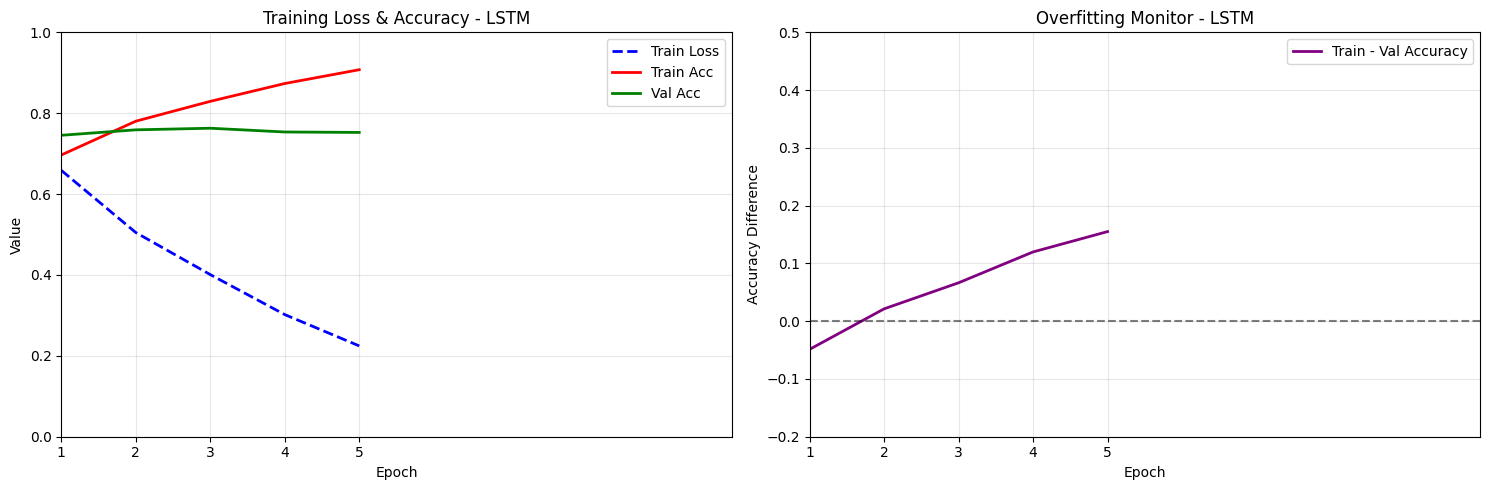


TRAINING SUMMARY
Model Name: LSTM
Final Train Loss: 0.2246
Final Train Accuracy: 0.9076
Final Val Loss: 0.7321
Final Val Accuracy: 0.7525
Best Val Accuracy: 0.7629 (Epoch 3)
Final Overfitting Gap: 0.1551


In [47]:
# 绘制训练曲线
plot_training_curves("LSTM", lstm_history)

# 打印训练摘要
print_training_summary("LSTM", lstm_history)

Testing:   0%|          | 0/58486 [00:00<?, ?it/s]


TEST RESULTS
Model Name: LSTM
Test Accuracy: 0.7580
Test Precision (weighted): 0.7575
Test Recall (weighted): 0.7580
Test F1 Score (weighted): 0.7563

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8122    0.7432    0.7761     18608
     Neutral     0.6670    0.6234    0.6445     14723
    Positive     0.7699    0.8477    0.8070     25155

    accuracy                         0.7580     58486
   macro avg     0.7497    0.7381    0.7425     58486
weighted avg     0.7575    0.7580    0.7563     58486



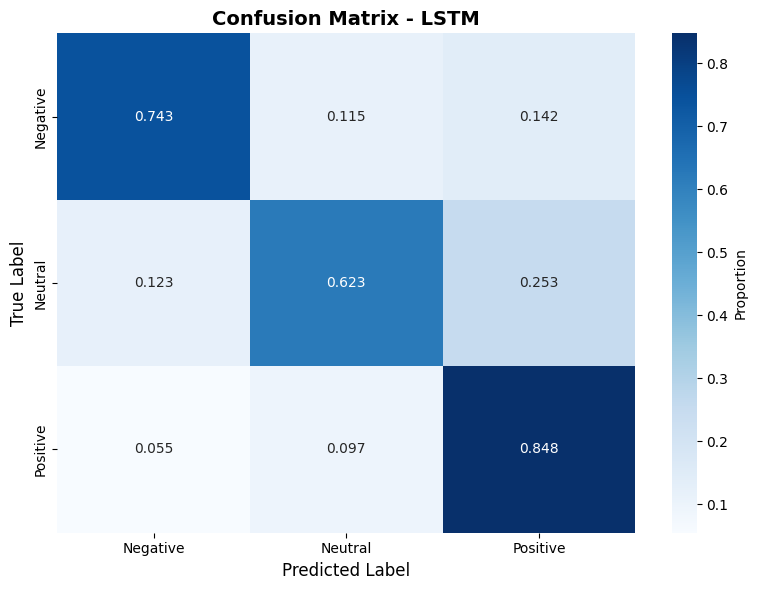


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8122, Recall=0.7432, F1=0.7761, Support=18608
 Neutral: Precision=0.6670, Recall=0.6234, F1=0.6445, Support=14723
Positive: Precision=0.7699, Recall=0.8477, F1=0.8070, Support=25155


In [48]:
# LSTM 测试过程 - 使用通用框架
lstm_test_results = test_model_comprehensive(
    model=lstm,
    model_name="LSTM", 
    test_loader=test_data_loader_lstm,
    device=device
)

In [49]:
# 保存LSTM训练结果
save_training_results(
    model=lstm,
    model_name="LSTM",
    set_epochs=num_epoch,
    actual_epochs=len(lstm_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=lstm_history,
    test_results=lstm_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: LSTM (LSTM)
  - 实际训练轮数: 5
  - 测试准确率: 0.7580
  - 测试F1分数: 0.7563
  - 记录时间: 2025-11-26 10:13:18
  - 总记录数: 56


## 5.8 Transformer

近年来，Transformer 架构在自然语言处理领域取得了显著的成功，成为了许多任务中的主流模型。

### 5.8.1 模型原理

#### (1) 注意力机制

相较于前面提到的传统 RNN 模型， Transformer 最显著的特点就是引入了 **注意力机制**（Attention Mechanism），这种机制使得模型能够更好地捕捉序列中不同位置之间的依赖关系，从而提升了模型的表达能力和性能。

注意力机制中，序列不同位置之间的依赖关系通过计算注意力权重来表示，其计算公式为
$$
\hat{\alpha}_s = \text{attn}(\boldsymbol{h}_s, \boldsymbol{h}_{t-1})
$$
$$
\alpha_s = \text{Softmax}(\hat{\boldsymbol{\alpha}})_s
$$
式中，$\boldsymbol{h}_s$ 表示源序列中 $s$ 时刻的状态；$\boldsymbol{h}_{t-1}$ 表示目标序列中前一个时刻的状态；$\text{attn}$ 是注意力计算公式，即利用两个输入状态的向量，计算一个源序列在 $s$ 时刻的注意力分数 $\hat{\alpha}_s$。

常用下面的公式计算两个向量 $\boldsymbol{q}$ 和 $\boldsymbol{k}$ 之间的注意力：
$$
\text{attn}(\boldsymbol{q}, \boldsymbol{k}) = \frac{\boldsymbol{q}^\top \boldsymbol{k}}{\sqrt{d_k}}
$$
式中，$d_k$ 是向量 $\boldsymbol{k}$ 的维度。这种方法可以避免因为维度 $d_k$ 过大导致点积结果过大。

#### (2) 自注意力机制

如果将注意力机制的思想应用于表示序列本身，那么就形成了 **自注意力机制**（Self-Attention Mechanism）。

具体地，假设输入为由 $n$ 个向量组成的序列 $\boldsymbol{x}_1, \boldsymbol{x}_2, \dots, \boldsymbol{x}_n$，输出为每个向量对应的新的向量表示 $\boldsymbol{y}_1, \boldsymbol{y}_2, \dots, \boldsymbol{y}_n$，其中所有向量的大小均为 $d$。那么，$\boldsymbol{y}_i$ 的计算公式为：
$$
\boldsymbol{y}_i = \sum_{j=1}^n \alpha_{ij}\boldsymbol{x}_j
$$
式中，$j$ 表示整个序列的索引值；$\alpha_{ij}$ 表示 $\boldsymbol{x}_i$ 与 $\boldsymbol{x}_j$ 之间的注意力权重，可以通过上面的 $\text{attn}$ 函数计算，然后经过 $\text{Softmax}$ 函数归一化得到。

不过，自注意模型还有以下几个问题：
1. 输入向量 $\boldsymbol{x}_i$ 同时承担了三种角色，即计算注意力权重的两个向量以及被加权的向量，导致其不容易学习
2. 自注意力计算结果互斥，无法同时关注多个输入
3. 只考虑了两个输入序列单元之间的关系，无法建模多个输入序列单元之间更复杂的关系
4. 在计算自注意力时，没有考虑输入的位置信息，因此无法对序列建模。

#### (3) 改进1：K、Q、V 向量表示

对于第一个“向量承担多种角色”的问题，Transformer 引入了 **查询**（Query）、**键**（Key） 和 **值**（Value）三种向量表示。具体来说，对于每个输入向量 $\boldsymbol{x}_i$，通过三个不同的线性变换，分别得到**查询向量** $\boldsymbol{q}_i = \boldsymbol{W}^{\mathrm{q}}\boldsymbol{x}_i$、**键向量** $\boldsymbol{k}_i = \boldsymbol{W}^{\mathrm{k}}\boldsymbol{x}_i$ 和 **值向量** $\boldsymbol{v}_i = \boldsymbol{W}^{\mathrm{v}}\boldsymbol{x}_i$。

于是，新的输出向量计算公式为
$$
\boldsymbol{y}_i = \sum_{j=1}^n \alpha_{ij}\boldsymbol{v}_j
$$
$$
\alpha_{ij} = \text{Softmax}(\hat{\boldsymbol{\alpha}}_i)_j
$$
$$
\hat{\alpha}_{ij} = \text{attn}(\boldsymbol{q}_i, \boldsymbol{k}_j)
$$

![Attention with QKV](pics\attention.svg)

#### (4) 改进2：多头注意力机制

对于“自注意力计算结果互斥”的问题，Transformer 引入了 **多头注意力机制**（Multi-Head Attention Mechanism）。具体来说，通过多个不同的线性变换，得到多个查询、键和值向量组，然后分别计算每组的自注意力，最后将多个自注意力的结果拼接起来，经过一个线性变换得到最终的输出。

多头自注意力机制相当于多个不同的自注意力模型的集成（Ensemble），可以增强模型的表达能力，使其能够捕捉到输入序列中不同位置之间的复杂关系。

![Multi-Head Attention](pics\multi-head-attention.svg)

#### (5) 改进3：Transformer 层堆叠

为解决“无法建模多个输入序列单元之间更复杂关系”的问题，Transformer 则是通过堆叠多个自注意力层和前馈神经网络层来实现更深层次的特征提取。每个自注意力层后面都跟着一个前馈神经网络层，这样可以使模型能够捕捉到输入序列中更复杂的关系。

除自注意力层、非线性层外，还可以使用层归一化（Layer Normalization）、残差连接（Residual Connection）等训练技巧，使得模型更容易学习。上面这些技术联合在一起，可以构成一个更大的 Transformer 层，也叫做 Transformer 块（Transformer Block）。

#### (6) 改进4：位置编码

最后，为了解决位置信息的问题，Transformer 引入了 **位置向量**（Position Embedding） 和 **位置编码**（Position Encoding）两种方式。

其中，位置向量与词向量类似，即为序列中每个绝对位置赋予一个低维、稠密的向量表示。

位置编码则是使用函数 $f: \mathbb{N} \to \mathbb{R}^d$，直接将位置索引值映射到一个 $d$ 维向量上，公式为
$$
\text{PosEnc}(p, i) = 
\begin{cases}
\sin\left(\frac{p}{10000^{\frac{i}{d}}}\right) & 如果 i 为偶数 \\
\cos\left(\frac{p}{10000^{\frac{i-1}{d}}}\right) & 否则
\end{cases}
$$
式中，$p$ 表示位置索引值，$0 \leq i < d$ 表示位置编码向量的维度索引。

使用的无论是位置向量还是位置编码，在获得一个位置对应的向量后，再与该位置对应的词向量相加，即可表示该位置的输入向量。

这样，即使词向量相同，但如果它们所处的位置不同，其最终的向量表示也不相同，从而解决了原始自注意力模型无法对序列进行建模的问题。

经过上述改进措施，就得到了 Transformer 模型的经典架构，如下图所示。

![Transformer Architecture](pics/transformer.svg)

### 5.8.2 模型构建

基于 Transformer 实现情感分类与使用 LSTM 模型类似，主要有一处不同，即需要定义 Transformer 模型，具体代码如下：

In [8]:
class Transformer(nn.Module):  #@save
    def __init__(
            self, 
            vocab_size, 
            embedding_dim, 
            num_class, 
            dim_feedforward=512, 
            num_head=2, 
            num_layers=2, 
            dropout=0.1, 
            max_len=512, 
            activation: str = "relu", 
            pretrained_embedding_matrix=None, 
            freeze=True
            ):
        super(Transformer, self).__init__()
        self.embedding_dim = embedding_dim
        if pretrained_embedding_matrix:
            self.embeddings = nn.Embedding.from_pretrained(pretrained_embedding_matrix, freeze=freeze)
        else:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = PositionalEncoding(embedding_dim, dropout, max_len)  # 位置编码

        encoder_layer = nn.TransformerEncoderLayer(embedding_dim, num_head, dim_feedforward, dropout, activation)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        self.output = nn.Linear(embedding_dim, num_class)

    def forward(self, inputs, lengths):
        inputs = torch.transpose(inputs, 0, 1)

        hidden_states = self.embeddings(inputs)
        hidden_states = self.position_embedding(hidden_states)

        lengths = lengths.to(inputs.device)
        attention_mask = length_to_mask(lengths) == False

        # 根据批次中每个序列长度生成 Mask 矩阵
        hidden_states = self.transformer(hidden_states, src_key_padding_mask=attention_mask)
        hidden_states = hidden_states[0, :, :]

        # 取第一个词元的输出结果作为分类层的输入
        outputs = self.output(hidden_states)
        return outputs

代码中，`length_to_mask` 函数比较关键，其作用是根据批次中每个序列的长度，生成掩码矩阵，以处理长度不一致的序列，忽略比较短的序列的无效部分，同时也是 `TransformerEncoder` 中调用函数所需的 `src_key_padding_mask` 参数。

例如，假设一个批次中有三个序列，实际长度分别为 $5$、$3$ 和 $4$，则 `lengths` 张量为 `[5, 3, 4]`。调用 `length_to_mask(lengths)` 后，得到的掩码矩阵 `mask` 为：
```python
tensor([[True, True, True, True, True],
        [True, True, True, False, False],
        [True, True, True, True, False]])
```
具体代码实现如下：

In [9]:
def length_to_mask(lengths):  #@save
    """根据序列长度生成掩码矩阵"""
    max_len = torch.max(lengths)
    mask = torch.arange(max_len, device=lengths.device).expand(lengths.shape[0], max_len) < lengths.unsqueeze(1)
    return mask

不过，由于 `src_key_padding_mask` 参数正好与 `length_to_mask` 函数生成的结果相反（无注意力部分为 `True`），因此还需要取反，即 `length_to_mask(lengths) == False`。

另外，还需要实现位置编码，代码如下：

In [10]:
import math

class PositionalEncoding(nn.Module):  #@save
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)) / d_model)
        pe[:, 0::2] = torch.sin(position * div_term)  # 对偶数位置编码
        pe[:, 1::2] = torch.cos(position * div_term)  # 对奇数位置编码
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)  # 不对位置编码层求梯度
        # self.max_len = max_len

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]  # 输入的词向量与位置编码相加
        return x

Transformer 的整理函数与 LSTM 的整理函数类似，需要记录每个序列的实际长度 `lengths`，以便在后续调用 Transformer 时使用。

In [27]:
collate_fn_trans = collate_fn_lstm  #@save

此外，如 5.2.3 节所述，Transformer 架构更适合使用 AdamW 优化器进行训练，因此在 `optimizer` 部分也做了相应修改。

In [ ]:
train_data_loader_trans = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=True)
val_data_loader_trans = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=False)
test_data_loader_trans = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_trans, shuffle=False)

# 加载模型（使用修复后的Transformer类）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer = Transformer(len(vocab), embedding_dim, num_class, max_len=512)  # 明确指定max_len=512
transformer.to(device)

weights = class_weights(train_idx)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
# optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(transformer.parameters(), lr=2e-5, weight_decay=1e-3)


e:\anaconda3\envs\nlpllma\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


### 5.6.3 模型训练与测试

In [ ]:
# 使用通用训练函数
transformer_history = train_model_with_validation(
    model=transformer,
    train_loader=train_data_loader_trans,
    val_loader=val_data_loader_trans,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)



Training Epoch 1:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 1/10
    Train Loss: 0.8779	Train Accuracy: 0.5464
    Valid Loss: 0.7997	Valid Accuracy: 0.6040
    Valid Precision: 0.6130	Valid Recall: 0.6040	Valid F1: 0.5868
    ✓ New best validation loss: 0.7997
--------------------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 2/10
    Train Loss: 0.7792	Train Accuracy: 0.6222
    Valid Loss: 0.7553	Valid Accuracy: 0.6264
    Valid Precision: 0.6472	Valid Recall: 0.6264	Valid F1: 0.6117
    ✓ New best validation loss: 0.7553
--------------------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 3/10
    Train Loss: 0.7404	Train Accuracy: 0.6472
    Valid Loss: 0.7243	Valid Accuracy: 0.6602
    Valid Precision: 0.6602	Valid Recall: 0.6602	Valid F1: 0.6551
    ✓ New best validation loss: 0.7243
--------------------------------------------------------------------------------


Training Epoch 4:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 4/10
    Train Loss: 0.7152	Train Accuracy: 0.6635
    Valid Loss: 0.7052	Valid Accuracy: 0.6698
    Valid Precision: 0.6710	Valid Recall: 0.6698	Valid F1: 0.6645
    ✓ New best validation loss: 0.7052
--------------------------------------------------------------------------------


Training Epoch 5:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 5/10
    Train Loss: 0.6934	Train Accuracy: 0.6769
    Valid Loss: 0.6917	Valid Accuracy: 0.6792
    Valid Precision: 0.6787	Valid Recall: 0.6792	Valid F1: 0.6724
    ✓ New best validation loss: 0.6917
--------------------------------------------------------------------------------


Training Epoch 6:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 6/10
    Train Loss: 0.6757	Train Accuracy: 0.6869
    Valid Loss: 0.6812	Valid Accuracy: 0.6809
    Valid Precision: 0.6844	Valid Recall: 0.6809	Valid F1: 0.6712
    ✓ New best validation loss: 0.6812
--------------------------------------------------------------------------------


Training Epoch 7:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 7/10
    Train Loss: 0.6584	Train Accuracy: 0.6964
    Valid Loss: 0.6732	Valid Accuracy: 0.6872
    Valid Precision: 0.6895	Valid Recall: 0.6872	Valid F1: 0.6779
    ✓ New best validation loss: 0.6732
--------------------------------------------------------------------------------


Training Epoch 8:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 8/10
    Train Loss: 0.6436	Train Accuracy: 0.7051
    Valid Loss: 0.6614	Valid Accuracy: 0.6973
    Valid Precision: 0.6960	Valid Recall: 0.6973	Valid F1: 0.6927
    ✓ New best validation loss: 0.6614
--------------------------------------------------------------------------------


Training Epoch 9:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 9/10
    Train Loss: 0.6294	Train Accuracy: 0.7134
    Valid Loss: 0.6575	Valid Accuracy: 0.7034
    Valid Precision: 0.7005	Valid Recall: 0.7034	Valid F1: 0.6999
    ✓ New best validation loss: 0.6575
--------------------------------------------------------------------------------


Training Epoch 10:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 10/10
    Train Loss: 0.6159	Train Accuracy: 0.7210
    Valid Loss: 0.6489	Valid Accuracy: 0.7055
    Valid Precision: 0.7045	Valid Recall: 0.7055	Valid F1: 0.7017
    ✓ New best validation loss: 0.6489
--------------------------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.7543    0.6704    0.7099     18609
     Neutral     0.6321    0.5506    0.5885     14746
    Positive     0.7101    0.8223    0.7621     25154

    accuracy                         0.7055     58509
   macro avg     0.6988    0.6811    0.6868     58509
weighted avg     0.7045    0.7055    0.7017     58509



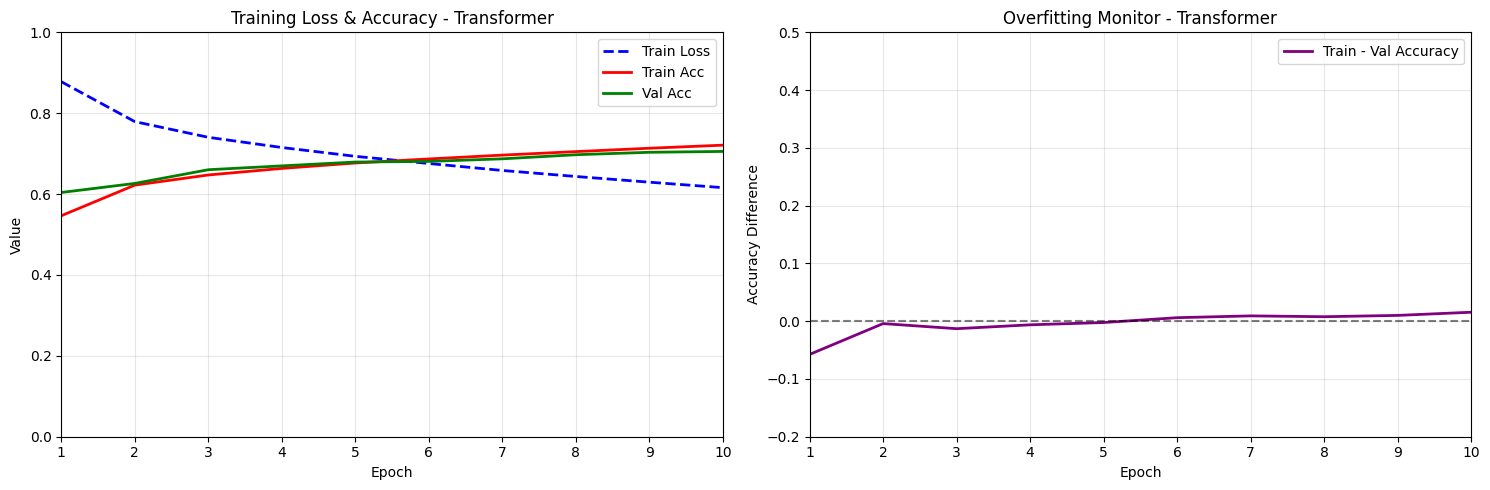


TRAINING SUMMARY
Model Name: Transformer
Final Train Loss: 0.6159
Final Train Accuracy: 0.7210
Final Val Loss: 0.6489
Final Val Accuracy: 0.7055
Best Val Accuracy: 0.7055 (Epoch 10)
Final Overfitting Gap: 0.0155


In [52]:
# 绘制训练曲线
plot_training_curves("Transformer", transformer_history)

# 打印训练摘要
print_training_summary("Transformer", transformer_history)

Testing:   0%|          | 0/58486 [00:00<?, ?it/s]


TEST RESULTS
Model Name: Transformer
Test Accuracy: 0.7006
Test Precision (weighted): 0.7000
Test Recall (weighted): 0.7006
Test F1 Score (weighted): 0.6970

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7496    0.6574    0.7005     18608
     Neutral     0.6264    0.5527    0.5872     14723
    Positive     0.7063    0.8192    0.7586     25155

    accuracy                         0.7006     58486
   macro avg     0.6941    0.6764    0.6821     58486
weighted avg     0.7000    0.7006    0.6970     58486



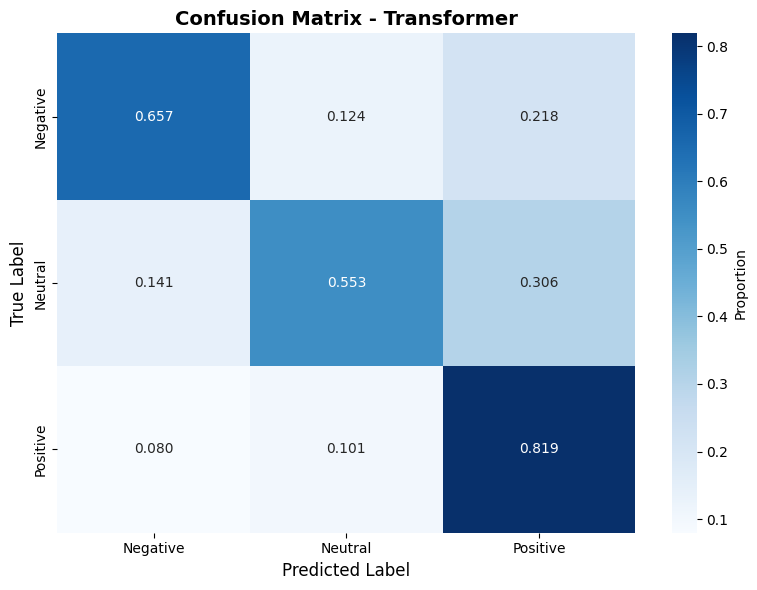


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7496, Recall=0.6574, F1=0.7005, Support=18608
 Neutral: Precision=0.6264, Recall=0.5527, F1=0.5872, Support=14723
Positive: Precision=0.7063, Recall=0.8192, F1=0.7586, Support=25155


In [53]:
# Transformer 测试过程 - 使用通用框架
transformer_test_results = test_model_comprehensive(
    model=transformer,
    model_name="Transformer",
    test_loader=test_data_loader_trans,
    device=device
)

In [54]:
# 保存Transformer训练结果
save_training_results(
    model=transformer,
    model_name="Transformer",
    set_epochs=num_epoch,
    actual_epochs=len(transformer_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=transformer_history,
    test_results=transformer_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: Transformer (Transformer)
  - 实际训练轮数: 10
  - 测试准确率: 0.7006
  - 测试F1分数: 0.6970
  - 记录时间: 2025-11-26 16:55:26
  - 总记录数: 58
